# Импортирование необходимых библиотек

In [1]:
import os
from datetime import datetime
import uuid
import tarfile
import numpy as np
import urllib.request
from tqdm import tqdm
from PIL import Image
import matplotlib.pyplot as plt

from sklearn.metrics import classification_report

import onnx
import pickle

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, TensorDataset
import torchvision
import torchvision.models as models
from torch.utils.tensorboard import SummaryWriter

from torchsummary import summary

2024-12-06 12:15:01.452282: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-12-06 12:15:02.197510: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [2]:
# Проверка наличия CUDA
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

if device.type == 'cuda':
    print("CUDA is available!")
    print(f"Device name: {torch.cuda.get_device_name(0)}")
    print(f"CUDA capability: {torch.cuda.get_device_capability(0)}")
    print(f"Driver version: {torch.version.cuda}")
    print(f"Device count: {torch.cuda.device_count()}")
    print(f"Current device: {torch.cuda.current_device()}")
else:
    print("CUDA is not available. Running on CPU.")

CUDA is available!
Device name: NVIDIA GeForce GTX 1650 Ti
CUDA capability: (7, 5)
Driver version: 12.1
Device count: 1
Current device: 0


# Загрузка и распаковка набора данных CIFAR100

In [3]:
def download_and_extract_cifar100(
    filename="cifar-100-python.tar.gz", 
    url="https://www.cs.toronto.edu/~kriz/cifar-100-python.tar.gz", 
    extract_dir="cifar-100-python"
    ):
    """
    Функция для скачивания и распаковки архива CIFAR-100.
    
    Args:
        filename (str): Имя архива, который нужно скачать.
        url (str): URL для скачивания архива.
        extract_dir (str): Папка, куда нужно распаковать архив.
    """
    
    # Проверяем наличие файла
    if not os.path.exists(filename):
        # Файла нет, скачиваем
        print(f"Скачивание {filename}...")
        urllib.request.urlretrieve(url, filename)
        print(f"Файл '{filename}' был успешно скачан.")
    else:
        print(f"Файл '{filename}' уже существует.")

    # Проверяем, был ли архив распакован
    if not os.path.exists(extract_dir):
        print(f"Распаковка {filename}...")
        with tarfile.open(filename, "r:gz") as tar:
            tar.extractall()
        print(f"Архив распакован в папку '{extract_dir}'.")
    else:
        print("Архив уже распакован.")
        
download_and_extract_cifar100()

Файл 'cifar-100-python.tar.gz' уже существует.
Архив уже распакован.


## Архитектуры модели

### Класс модели CIFAR100

In [4]:
class CIFAR100Trainer:
    def __init__(self, classes, batch_size=128, lr_rate=1e-4, patience=2, factor=0.9, dropout_rate=0.5, experiment_name='cifar100_cnn', device=None):
        self.classes = classes
        self.batch_size = batch_size
        self.lr_rate = lr_rate
        self.dropout_rate = dropout_rate
        self.criterion = nn.CrossEntropyLoss()
        self.patience = patience
        self.factor = factor
        self.device = self.get_device(device)
        self.history = {"epoch": [], "loss": []}  # История обучения
        # Загрузка названий классов
        self.class_names = self.load_class_names()
        # Инициализация логгера
        self.writer = self.initialize_log_dir(experiment_name)

        # Чтение тренировочной выборки (обучающих данных)
        with open('cifar-100-python/train', 'rb') as f:
            data_train = pickle.load(f, encoding='latin1')

        # Чтение тестовой выборки (тестовых данных)
        with open('cifar-100-python/test', 'rb') as f:
            data_test = pickle.load(f, encoding='latin1')

        # Фильтрация данных и создание датасетов
        self.train_dataset = self.prepare_data(data_train, 'train')
        self.test_dataset = self.prepare_data(data_test, 'test')

        # Загрузка данных в батчи
        self.train_loader = DataLoader(self.train_dataset, batch_size=self.batch_size, shuffle=True)
        self.test_loader = DataLoader(self.test_dataset, batch_size=self.batch_size, shuffle=False)

    def initialize_log_dir(self, experiment_name):
        """Создает уникальную директорию для эксперимента и инициализирует SummaryWriter."""
        self.experiment_name = experiment_name  # Сохраняем название эксперимента
        self.log_dir = f'logs/{experiment_name}'  # Базовый путь для логов
        # Проверка существования директории и генерация нового имени, если необходимо
        i = 0
        while os.path.exists(self.log_dir):
            self.log_dir = f'logs/{experiment_name}_{i}'
            i += 1
        os.makedirs(self.log_dir)   # Создаем директорию, если она не существует
        # Вывод информации о названии эксперимента
        print(f"Директория для эксперимента '{experiment_name}' инициализирована по пути: {self.log_dir}")
        # Сохраняем уникальное имя для использования в save_model
        self.unique_experiment_name = os.path.basename(self.log_dir)  

        return SummaryWriter(log_dir=self.log_dir) # Возвращаем инициализированный SummaryWriter

    def log_model_graph(self, model):
        """Визуализирует граф модели в TensorBoard."""
        dummy_input = torch.randn(1, 3, 32, 32).to('cpu')  # Размер входа для CIFAR100 (N, C, H, W)
        
        self.writer.add_graph(model, dummy_input)  # Добавляем граф модели
        print(f"Граф модели добавлен в лог: {self.writer.log_dir}")

    def log_hparams_and_metrics(self, accuracy):
        hparams = {
            'batch_size': self.batch_size,
            'learning_rate': self.lr_rate,
            'dropout_rate': self.dropout_rate,
            'epochs': self.epochs
        }
        # Получение текущего времени в читаемом формате
        timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
        run_name = f"{timestamp}"  # Читаемое имя
    
        # Логирование гиперпараметров и метрик
        self.writer.add_hparams(hparams, { 
            'accuracy': accuracy,
        }, run_name=run_name)
        
        self.writer.close()
        
    def close_writer(self):
        """Закрывает SummaryWriter."""
        self.writer.close()
        print("SummaryWriter закрыт.")

    def load_class_names(self):
        """Загружает названия классов из мета-файла."""
        with open('cifar-100-python/meta', 'rb') as f:
            meta = pickle.load(f, encoding='latin1')
        return meta['fine_label_names']

    def prepare_data(self, data, part):
        """Фильтрация данных и преобразование в TensorDataset."""
        X = data['data'].reshape(-1, 3, 32, 32)  # Данные в формате NCHW
        y = np.array(data['fine_labels'])

        mask = np.isin(y, self.classes)
        X = X[mask].copy()
        y = y[mask].copy()
        y = np.unique(y, return_inverse=1)[1]

        tensor_x = torch.Tensor(X)
        tensor_y = F.one_hot(torch.Tensor(y).to(torch.int64), num_classes=len(self.classes)) / 1.
        dataset = TensorDataset(tensor_x, tensor_y)
        return dataset
        
    def train(self, model, epochs=10, max_early_stopping_counter=100):
        self.epochs = epochs
        early_stopping_counter = 0
        best_loss = float('inf')
        model = model.to(self.device)
        optimizer = optim.Adam(model.parameters(), lr=self.lr_rate)
        self.scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', patience=self.patience, factor=self.factor)

        self.history = {"epoch": [], "loss": []}  # Инициализация истории

        for epoch in range(epochs):
            model.train()  # Установка модели в режим обучения
            running_loss = 0.0

            progress_bar = tqdm(self.train_loader, desc=f'Epoch {epoch+1}/{epochs}', unit="batch")
            for batch_idx, (data, target) in enumerate(progress_bar):
                data, target = data.to(self.device), target.to(self.device)
                optimizer.zero_grad()
                # Вызов метода forward() модели
                output = model.forward(data) 
                loss = self.criterion(output, target)
                loss.backward()
                optimizer.step()

                running_loss += loss.item()
                # Получение текущего значения learning rate
                current_learning_rate = optimizer.param_groups[0]['lr']
                progress_bar.set_postfix(loss=f"{loss:.6f}", lr=f"{current_learning_rate:.6f}")
                
            average_loss = running_loss / len(self.train_loader)
            self.history["epoch"].append(epoch + 1)
            self.history["loss"].append(average_loss)  # Сохранение средней потери
    
            # Логирование потерь в TensorBoard
            self.writer.add_scalar('Loss/train', average_loss, epoch)
            self.writer.add_scalar('Learning Rate', optimizer.param_groups[0]['lr'], epoch)
            print(f'Epoch: {epoch+1}/{epochs}, Loss: {running_loss/len(self.train_loader):.6f}')
            
            # Обновляем планировщик в каждой эпохе
            self.scheduler.step(average_loss)

            # Early Stopping
            if average_loss < best_loss:
                best_loss = average_loss
                early_stopping_counter = 0
            else:
                early_stopping_counter += 1

            if early_stopping_counter >= max_early_stopping_counter:  # Параметр patience для Early Stopping
                print("Early stopping activated.")
                break

    def evaluate(self, model):
        model = model.to(self.device)
        model.eval()  # Установка модели в режим оценки
        
        # Обрабатываем обе выборки: тренировочную и тестовую
        dataloaders = {'train': self.train_loader, 'test': self.test_loader}
        
        for part in ['train', 'test']:
            all_predicted = []
            all_target = []
            with torch.no_grad():
                for data, target in dataloaders[part]:
                    data, target = data.to(self.device), target.to(self.device)

                    output = model(data)
                    
                    # Получаем предсказания
                    _, predicted = torch.max(output.data, 1)
                    
                    # Преобразуем target обратно в одномерный тензор
                    target_indices = torch.argmax(target, dim=1)
                    
                    all_predicted.extend(predicted.cpu().numpy())
                    all_target.extend(target_indices.cpu().numpy())
            
            # Преобразуем списки в массивы NumPy
            all_predicted = np.array(all_predicted)
            all_target = np.array(all_target)
            
            # Выводим наименования классов для выбранных индексов
            selected_class_names = [self.class_names[i] for i in self.classes]
            
            # Выводим отчет о классификации
            print(f"Classification report for {part} dataset:")
            report = classification_report(all_target, all_predicted, target_names=selected_class_names, zero_division=0, digits=4)
            print(report)
            print('-' * 50)
            
        # Вычисляем и логируем точность
        accuracy = np.sum(all_predicted == all_target) / len(all_target)
        self.writer.add_scalar(f'Accuracy/{part}', accuracy, len(self.history["epoch"]) - 1)
        
        self.log_hparams_and_metrics(accuracy)

    def save_model(self, model, path='models/'):
        # Формируем название модели на основе уникального имени эксперимента
        model_name = f"{self.unique_experiment_name}_model.onnx"  # Используем уникальное имя эксперимента
        
        # Создаем полный путь для сохранения модели
        filepath = os.path.join(path, model_name)  # Корректное соединение пути и имени файла
        
        # Убедимся, что директория для сохранения существует
        os.makedirs(path, exist_ok=True)  # Создаем директорию, если она не существует

        # Входной тензор для модели (с учетом правильного порядка: (N, C, H, W))
        dummy_input = torch.randn(1, 3, 32, 32, requires_grad=True).to(self.device)

        # Экспорт модели
        torch.onnx.export(
            model,               # модель
            dummy_input,         # входной тензор
            filepath,            # куда сохранить
            export_params=True,  # сохраняет веса обученных параметров внутри файла модели
            opset_version=9,    # версия ONNX
            do_constant_folding=True,  # следует ли выполнять укорачивание констант для оптимизации
            input_names=['input'],    # имя входного слоя
            output_names=['output'],   # имя выходного слоя
            dynamic_axes={'input': {0: 'batch_size'},    # динамичные оси
                          'output': {0: 'batch_size'}}
        )
        
        # Вывод информации о сохраненной модели
        print(f"Model saved as: {model_name}")

    @staticmethod
    def get_device(select=None):
        """
        Определение устройства для вычислений (CPU или GPU).
        Args:
            select (str, optional): Выбор устройства ('cpu', 'cuda'). По умолчанию None.
            torch.device: Устройство для вычислений.
        """
        if select is None or select == 'cuda':
            return torch.device('cuda' if torch.cuda.is_available() else 'cpu')
        return torch.device('cpu')

    def plot_training_history(self, window_size = 5):
        fig, axs = plt.subplots(1, 2, figsize=(14, 6))
    
        # Преобразуем список эпох для оси X
        epochs = self.history["epoch"]
        loss = self.history["loss"]
            
        # Вычисляем скользящее среднее
        smoothed_loss = np.convolve(loss, np.ones(window_size)/window_size, mode='valid')
    
        # Первый график: Полная история с скользящим средним
        axs[0].plot(epochs, loss, marker='o', linestyle='-', color='b', markersize=5, label='Loss')
        axs[0].plot(epochs[window_size-1:], smoothed_loss, color='orange', label='Smoothed Loss (Moving Average)')
        axs[0].set_xlabel('Epoch')
        axs[0].set_ylabel('Average Loss')
        axs[0].set_title('Loss Function (Full History)')
        axs[0].grid(True)
        axs[0].legend()
    
        # Второй график: Половина истории с скользящим средним
        mid_index = len(epochs) // 2
        axs[1].plot(epochs[mid_index:], loss[mid_index:], marker='o', linestyle='-', color='b', markersize=5, label='Loss')
        axs[1].plot(epochs[mid_index + window_size - 1:], smoothed_loss[mid_index:], color='orange', label='Smoothed Loss (Moving Average)')
        axs[1].set_xlabel('Epoch')
        axs[1].set_ylabel('Average Loss')
        axs[1].set_title('Loss Function (Second Half of Training)')
        axs[1].grid(True)
        axs[1].legend()
    
        plt.tight_layout()
        plt.show()

### Нормализация

In [5]:
class Normalize(nn.Module):
    def __init__(self, mean, std):
        super(Normalize, self).__init__()
        self.mean = torch.tensor(mean)
        self.std = torch.tensor(std)

    def forward(self, input):
        device = input.device  # Получаем устройство данных
        self.mean = self.mean.to(device)  # Переносим тензоры на это устройство
        self.std = self.std.to(device)

        x = input / 255.0
        x = x - self.mean[None, :, None, None]  # Убедитесь, что mean/std правильно транслируются
        x = x / self.std[None, :, None, None]
        return x

### Архитектура модели

In [6]:
class CIFAR100ModelCNN(nn.Module):
    def __init__(self, hidden_layers=[64, 128, 256], dropout_rate=0.5, num_classes=100):
        super(CIFAR100ModelCNN, self).__init__()
        
        # Устанавливаем параметры нормализации (они могут меняться в зависимости от ваших данных)
        self.normalize = Normalize([0.5074, 0.4867, 0.4411], [0.2011, 0.1987, 0.2025])
        
        layers = []
        input_channels = 3
        for layer_dim in hidden_layers:
            layers.append(nn.Conv2d(input_channels, layer_dim, kernel_size=3, stride=1, padding=1))
            layers.append(nn.ReLU(inplace=True))
            layers.append(nn.MaxPool2d(kernel_size=2, stride=2))
            input_channels = layer_dim

        self.conv_layers = nn.Sequential(*layers)
        self.classifier_conv = nn.Conv2d(hidden_layers[-1], num_classes, kernel_size=1)

    def forward(self, x):
        x = self.normalize(x)  # Применяем нормализацию
        x = self.conv_layers(x)
        x = self.classifier_conv(x)
        x = F.adaptive_avg_pool2d(x, 1)  # Global average pooling
        x = torch.flatten(x, 1)
        return x

## Установки параметров

### По варианту

In [7]:
CLASSES = [94, 21, 51]

In [8]:
# Счетчик экспериментов
count_experiments = 1

## Машинное обучение 

### Эксперимент №1

#### Гиперпараметры

In [9]:
batch_size=2**5
epochs=100
lr_rate=1e-4
dropout_rate=0.5
hidden_layers=[2**4, 2**6, 2**4]

#### Инициализация модели

In [10]:
%%time
trainer = CIFAR100Trainer(classes=CLASSES, batch_size=batch_size, lr_rate=lr_rate, dropout_rate=dropout_rate)

Директория для эксперимента 'cifar100_cnn' инициализирована по пути: logs/cifar100_cnn_4
CPU times: user 166 ms, sys: 334 ms, total: 499 ms
Wall time: 354 ms


In [11]:
%%time
cifar100 = CIFAR100ModelCNN(
    hidden_layers=hidden_layers, 
    dropout_rate=dropout_rate, 
    num_classes=CLASSES.__len__()
)

CPU times: user 19.2 ms, sys: 2.54 ms, total: 21.7 ms
Wall time: 2.65 ms


In [12]:
trainer.log_model_graph(cifar100)

Граф модели добавлен в лог: logs/cifar100_cnn_4


#### Информация о модели

In [13]:
cifar100.to(device)

CIFAR100ModelCNN(
  (normalize): Normalize()
  (conv_layers): Sequential(
    (0): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(16, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(64, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (classifier_conv): Conv2d(16, 3, kernel_size=(1, 1), stride=(1, 1))
)

In [14]:
summary(cifar100, input_size=(3, 32, 32))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
         Normalize-1            [-1, 3, 32, 32]               0
            Conv2d-2           [-1, 16, 32, 32]             448
              ReLU-3           [-1, 16, 32, 32]               0
         MaxPool2d-4           [-1, 16, 16, 16]               0
            Conv2d-5           [-1, 64, 16, 16]           9,280
              ReLU-6           [-1, 64, 16, 16]               0
         MaxPool2d-7             [-1, 64, 8, 8]               0
            Conv2d-8             [-1, 16, 8, 8]           9,232
              ReLU-9             [-1, 16, 8, 8]               0
        MaxPool2d-10             [-1, 16, 4, 4]               0
           Conv2d-11              [-1, 3, 4, 4]              51
Total params: 19,011
Trainable params: 19,011
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.01
Forward/ba

#### Обучение

In [15]:
%%time
trainer.train(cifar100, epochs)

Epoch 1/100: 100%|████████████████████| 47/47 [00:00<00:00, 136.73batch/s, loss=1.062607, lr=0.000100]


Epoch: 1/100, Loss: 1.102992


Epoch 2/100: 100%|████████████████████| 47/47 [00:00<00:00, 213.31batch/s, loss=1.019104, lr=0.000100]


Epoch: 2/100, Loss: 1.048393


Epoch 3/100: 100%|████████████████████| 47/47 [00:00<00:00, 221.04batch/s, loss=0.857266, lr=0.000100]


Epoch: 3/100, Loss: 0.945912


Epoch 4/100: 100%|████████████████████| 47/47 [00:00<00:00, 237.16batch/s, loss=0.775155, lr=0.000100]


Epoch: 4/100, Loss: 0.848678


Epoch 5/100: 100%|████████████████████| 47/47 [00:00<00:00, 236.13batch/s, loss=0.990657, lr=0.000100]


Epoch: 5/100, Loss: 0.796368


Epoch 6/100: 100%|████████████████████| 47/47 [00:00<00:00, 267.63batch/s, loss=0.592107, lr=0.000100]


Epoch: 6/100, Loss: 0.768743


Epoch 7/100: 100%|████████████████████| 47/47 [00:00<00:00, 256.46batch/s, loss=0.638822, lr=0.000100]


Epoch: 7/100, Loss: 0.748673


Epoch 8/100: 100%|████████████████████| 47/47 [00:00<00:00, 290.20batch/s, loss=0.782225, lr=0.000100]


Epoch: 8/100, Loss: 0.728281


Epoch 9/100: 100%|████████████████████| 47/47 [00:00<00:00, 260.10batch/s, loss=0.685329, lr=0.000100]


Epoch: 9/100, Loss: 0.709346


Epoch 10/100: 100%|███████████████████| 47/47 [00:00<00:00, 245.52batch/s, loss=0.760262, lr=0.000100]


Epoch: 10/100, Loss: 0.691184


Epoch 11/100: 100%|███████████████████| 47/47 [00:00<00:00, 254.28batch/s, loss=0.602349, lr=0.000100]


Epoch: 11/100, Loss: 0.672165


Epoch 12/100: 100%|███████████████████| 47/47 [00:00<00:00, 263.98batch/s, loss=0.586127, lr=0.000100]


Epoch: 12/100, Loss: 0.653864


Epoch 13/100: 100%|███████████████████| 47/47 [00:00<00:00, 261.17batch/s, loss=0.658666, lr=0.000100]


Epoch: 13/100, Loss: 0.638981


Epoch 14/100: 100%|███████████████████| 47/47 [00:00<00:00, 256.24batch/s, loss=0.637073, lr=0.000100]


Epoch: 14/100, Loss: 0.619901


Epoch 15/100: 100%|███████████████████| 47/47 [00:00<00:00, 238.13batch/s, loss=0.558863, lr=0.000100]


Epoch: 15/100, Loss: 0.608217


Epoch 16/100: 100%|███████████████████| 47/47 [00:00<00:00, 202.95batch/s, loss=0.771820, lr=0.000100]


Epoch: 16/100, Loss: 0.598536


Epoch 17/100: 100%|███████████████████| 47/47 [00:00<00:00, 276.49batch/s, loss=0.541733, lr=0.000100]


Epoch: 17/100, Loss: 0.585156


Epoch 18/100: 100%|███████████████████| 47/47 [00:00<00:00, 254.74batch/s, loss=0.531832, lr=0.000100]


Epoch: 18/100, Loss: 0.578985


Epoch 19/100: 100%|███████████████████| 47/47 [00:00<00:00, 270.75batch/s, loss=0.548215, lr=0.000100]


Epoch: 19/100, Loss: 0.567386


Epoch 20/100: 100%|███████████████████| 47/47 [00:00<00:00, 270.07batch/s, loss=0.474195, lr=0.000100]


Epoch: 20/100, Loss: 0.561329


Epoch 21/100: 100%|███████████████████| 47/47 [00:00<00:00, 268.85batch/s, loss=0.587143, lr=0.000100]


Epoch: 21/100, Loss: 0.554358


Epoch 22/100: 100%|███████████████████| 47/47 [00:00<00:00, 247.72batch/s, loss=0.467659, lr=0.000100]


Epoch: 22/100, Loss: 0.547707


Epoch 23/100: 100%|███████████████████| 47/47 [00:00<00:00, 246.07batch/s, loss=0.569800, lr=0.000100]


Epoch: 23/100, Loss: 0.535402


Epoch 24/100: 100%|███████████████████| 47/47 [00:00<00:00, 249.19batch/s, loss=0.568250, lr=0.000100]


Epoch: 24/100, Loss: 0.529506


Epoch 25/100: 100%|███████████████████| 47/47 [00:00<00:00, 246.09batch/s, loss=0.439189, lr=0.000100]


Epoch: 25/100, Loss: 0.522864


Epoch 26/100: 100%|███████████████████| 47/47 [00:00<00:00, 218.79batch/s, loss=0.402250, lr=0.000100]


Epoch: 26/100, Loss: 0.515042


Epoch 27/100: 100%|███████████████████| 47/47 [00:00<00:00, 240.75batch/s, loss=0.511132, lr=0.000100]


Epoch: 27/100, Loss: 0.507073


Epoch 28/100: 100%|███████████████████| 47/47 [00:00<00:00, 236.43batch/s, loss=0.465631, lr=0.000100]


Epoch: 28/100, Loss: 0.506304


Epoch 29/100: 100%|███████████████████| 47/47 [00:00<00:00, 237.58batch/s, loss=0.457457, lr=0.000100]

Epoch: 29/100, Loss: 0.492619



Epoch 30/100: 100%|███████████████████| 47/47 [00:00<00:00, 230.59batch/s, loss=0.460736, lr=0.000100]


Epoch: 30/100, Loss: 0.489278


Epoch 31/100: 100%|███████████████████| 47/47 [00:00<00:00, 246.71batch/s, loss=0.291361, lr=0.000100]


Epoch: 31/100, Loss: 0.482575


Epoch 32/100: 100%|███████████████████| 47/47 [00:00<00:00, 237.66batch/s, loss=0.593507, lr=0.000100]


Epoch: 32/100, Loss: 0.485726


Epoch 33/100: 100%|███████████████████| 47/47 [00:00<00:00, 234.10batch/s, loss=0.541619, lr=0.000100]


Epoch: 33/100, Loss: 0.473408


Epoch 34/100: 100%|███████████████████| 47/47 [00:00<00:00, 220.12batch/s, loss=0.405562, lr=0.000100]


Epoch: 34/100, Loss: 0.467957


Epoch 35/100: 100%|███████████████████| 47/47 [00:00<00:00, 231.97batch/s, loss=0.574111, lr=0.000100]


Epoch: 35/100, Loss: 0.462350


Epoch 36/100: 100%|███████████████████| 47/47 [00:00<00:00, 239.73batch/s, loss=0.431135, lr=0.000100]


Epoch: 36/100, Loss: 0.458733


Epoch 37/100: 100%|███████████████████| 47/47 [00:00<00:00, 247.15batch/s, loss=0.506345, lr=0.000100]


Epoch: 37/100, Loss: 0.459648


Epoch 38/100: 100%|███████████████████| 47/47 [00:00<00:00, 237.16batch/s, loss=0.313843, lr=0.000100]


Epoch: 38/100, Loss: 0.455809


Epoch 39/100: 100%|███████████████████| 47/47 [00:00<00:00, 236.86batch/s, loss=0.350514, lr=0.000100]


Epoch: 39/100, Loss: 0.442606


Epoch 40/100: 100%|███████████████████| 47/47 [00:00<00:00, 231.54batch/s, loss=0.357780, lr=0.000100]


Epoch: 40/100, Loss: 0.441318


Epoch 41/100: 100%|███████████████████| 47/47 [00:00<00:00, 252.53batch/s, loss=0.698437, lr=0.000100]


Epoch: 41/100, Loss: 0.433894


Epoch 42/100: 100%|███████████████████| 47/47 [00:00<00:00, 217.69batch/s, loss=0.476836, lr=0.000100]


Epoch: 42/100, Loss: 0.423730


Epoch 43/100: 100%|███████████████████| 47/47 [00:00<00:00, 224.77batch/s, loss=0.434537, lr=0.000100]


Epoch: 43/100, Loss: 0.423266


Epoch 44/100: 100%|███████████████████| 47/47 [00:00<00:00, 229.68batch/s, loss=0.504944, lr=0.000100]


Epoch: 44/100, Loss: 0.420178


Epoch 45/100: 100%|███████████████████| 47/47 [00:00<00:00, 230.32batch/s, loss=0.638171, lr=0.000100]


Epoch: 45/100, Loss: 0.413518


Epoch 46/100: 100%|███████████████████| 47/47 [00:00<00:00, 223.85batch/s, loss=0.359066, lr=0.000100]


Epoch: 46/100, Loss: 0.415251


Epoch 47/100: 100%|███████████████████| 47/47 [00:00<00:00, 217.25batch/s, loss=0.235191, lr=0.000100]


Epoch: 47/100, Loss: 0.405313


Epoch 48/100: 100%|███████████████████| 47/47 [00:00<00:00, 249.45batch/s, loss=0.313131, lr=0.000100]


Epoch: 48/100, Loss: 0.400035


Epoch 49/100: 100%|███████████████████| 47/47 [00:00<00:00, 265.50batch/s, loss=0.295377, lr=0.000100]


Epoch: 49/100, Loss: 0.400654


Epoch 50/100: 100%|███████████████████| 47/47 [00:00<00:00, 261.25batch/s, loss=0.561906, lr=0.000100]


Epoch: 50/100, Loss: 0.395661


Epoch 51/100: 100%|███████████████████| 47/47 [00:00<00:00, 245.75batch/s, loss=0.534090, lr=0.000100]


Epoch: 51/100, Loss: 0.391205


Epoch 52/100: 100%|███████████████████| 47/47 [00:00<00:00, 243.27batch/s, loss=0.283571, lr=0.000100]


Epoch: 52/100, Loss: 0.386135


Epoch 53/100: 100%|███████████████████| 47/47 [00:00<00:00, 275.75batch/s, loss=0.407057, lr=0.000100]


Epoch: 53/100, Loss: 0.386876


Epoch 54/100: 100%|███████████████████| 47/47 [00:00<00:00, 245.98batch/s, loss=0.379476, lr=0.000100]


Epoch: 54/100, Loss: 0.379119


Epoch 55/100: 100%|███████████████████| 47/47 [00:00<00:00, 253.17batch/s, loss=0.464801, lr=0.000100]


Epoch: 55/100, Loss: 0.377115


Epoch 56/100: 100%|███████████████████| 47/47 [00:00<00:00, 262.12batch/s, loss=0.319365, lr=0.000100]


Epoch: 56/100, Loss: 0.373939


Epoch 57/100: 100%|███████████████████| 47/47 [00:00<00:00, 255.38batch/s, loss=0.415311, lr=0.000100]


Epoch: 57/100, Loss: 0.375252


Epoch 58/100: 100%|███████████████████| 47/47 [00:00<00:00, 214.67batch/s, loss=0.419167, lr=0.000100]


Epoch: 58/100, Loss: 0.374150


Epoch 59/100: 100%|███████████████████| 47/47 [00:00<00:00, 252.72batch/s, loss=0.414717, lr=0.000100]


Epoch: 59/100, Loss: 0.368993


Epoch 60/100: 100%|███████████████████| 47/47 [00:00<00:00, 261.02batch/s, loss=0.337452, lr=0.000100]


Epoch: 60/100, Loss: 0.361624


Epoch 61/100: 100%|███████████████████| 47/47 [00:00<00:00, 278.16batch/s, loss=0.341883, lr=0.000100]


Epoch: 61/100, Loss: 0.355117


Epoch 62/100: 100%|███████████████████| 47/47 [00:00<00:00, 208.26batch/s, loss=0.388156, lr=0.000100]


Epoch: 62/100, Loss: 0.360974


Epoch 63/100: 100%|███████████████████| 47/47 [00:00<00:00, 210.01batch/s, loss=0.508910, lr=0.000100]


Epoch: 63/100, Loss: 0.350083


Epoch 64/100: 100%|███████████████████| 47/47 [00:00<00:00, 229.88batch/s, loss=0.341977, lr=0.000100]


Epoch: 64/100, Loss: 0.347907


Epoch 65/100: 100%|███████████████████| 47/47 [00:00<00:00, 228.62batch/s, loss=0.281658, lr=0.000100]


Epoch: 65/100, Loss: 0.346318


Epoch 66/100: 100%|███████████████████| 47/47 [00:00<00:00, 227.87batch/s, loss=0.385976, lr=0.000100]


Epoch: 66/100, Loss: 0.342478


Epoch 67/100: 100%|███████████████████| 47/47 [00:00<00:00, 234.36batch/s, loss=0.456888, lr=0.000100]


Epoch: 67/100, Loss: 0.336860


Epoch 68/100: 100%|███████████████████| 47/47 [00:00<00:00, 234.23batch/s, loss=0.715849, lr=0.000100]


Epoch: 68/100, Loss: 0.344652


Epoch 69/100: 100%|███████████████████| 47/47 [00:00<00:00, 226.24batch/s, loss=0.316227, lr=0.000100]


Epoch: 69/100, Loss: 0.333343


Epoch 70/100: 100%|███████████████████| 47/47 [00:00<00:00, 241.26batch/s, loss=0.233478, lr=0.000100]


Epoch: 70/100, Loss: 0.331384


Epoch 71/100: 100%|███████████████████| 47/47 [00:00<00:00, 232.12batch/s, loss=0.479140, lr=0.000100]


Epoch: 71/100, Loss: 0.331219


Epoch 72/100: 100%|███████████████████| 47/47 [00:00<00:00, 204.15batch/s, loss=0.314766, lr=0.000100]


Epoch: 72/100, Loss: 0.335701


Epoch 73/100: 100%|███████████████████| 47/47 [00:00<00:00, 180.90batch/s, loss=0.428148, lr=0.000100]


Epoch: 73/100, Loss: 0.323949


Epoch 74/100: 100%|███████████████████| 47/47 [00:00<00:00, 232.92batch/s, loss=0.206481, lr=0.000100]


Epoch: 74/100, Loss: 0.322584


Epoch 75/100: 100%|███████████████████| 47/47 [00:00<00:00, 221.96batch/s, loss=0.287340, lr=0.000100]


Epoch: 75/100, Loss: 0.321944


Epoch 76/100: 100%|███████████████████| 47/47 [00:00<00:00, 214.78batch/s, loss=0.267031, lr=0.000100]


Epoch: 76/100, Loss: 0.318735


Epoch 77/100: 100%|███████████████████| 47/47 [00:00<00:00, 221.15batch/s, loss=0.192739, lr=0.000100]


Epoch: 77/100, Loss: 0.313573


Epoch 78/100: 100%|███████████████████| 47/47 [00:00<00:00, 233.10batch/s, loss=0.186617, lr=0.000100]


Epoch: 78/100, Loss: 0.311614


Epoch 79/100: 100%|███████████████████| 47/47 [00:00<00:00, 250.25batch/s, loss=0.365866, lr=0.000100]


Epoch: 79/100, Loss: 0.309627


Epoch 80/100: 100%|███████████████████| 47/47 [00:00<00:00, 277.15batch/s, loss=0.295549, lr=0.000100]


Epoch: 80/100, Loss: 0.306839


Epoch 81/100: 100%|███████████████████| 47/47 [00:00<00:00, 242.53batch/s, loss=0.304405, lr=0.000100]


Epoch: 81/100, Loss: 0.311246


Epoch 82/100: 100%|███████████████████| 47/47 [00:00<00:00, 256.59batch/s, loss=0.347029, lr=0.000100]


Epoch: 82/100, Loss: 0.318676


Epoch 83/100: 100%|███████████████████| 47/47 [00:00<00:00, 250.35batch/s, loss=0.259785, lr=0.000100]


Epoch: 83/100, Loss: 0.300507


Epoch 84/100: 100%|███████████████████| 47/47 [00:00<00:00, 246.61batch/s, loss=0.191250, lr=0.000100]


Epoch: 84/100, Loss: 0.298955


Epoch 85/100: 100%|███████████████████| 47/47 [00:00<00:00, 245.37batch/s, loss=0.390077, lr=0.000100]


Epoch: 85/100, Loss: 0.301554


Epoch 86/100: 100%|███████████████████| 47/47 [00:00<00:00, 254.06batch/s, loss=0.335749, lr=0.000100]


Epoch: 86/100, Loss: 0.308275


Epoch 87/100: 100%|███████████████████| 47/47 [00:00<00:00, 247.04batch/s, loss=0.232506, lr=0.000100]


Epoch: 87/100, Loss: 0.293140


Epoch 88/100: 100%|███████████████████| 47/47 [00:00<00:00, 235.50batch/s, loss=0.384866, lr=0.000100]


Epoch: 88/100, Loss: 0.298150


Epoch 89/100: 100%|███████████████████| 47/47 [00:00<00:00, 226.36batch/s, loss=0.176125, lr=0.000100]


Epoch: 89/100, Loss: 0.290927


Epoch 90/100: 100%|███████████████████| 47/47 [00:00<00:00, 239.10batch/s, loss=0.201592, lr=0.000100]


Epoch: 90/100, Loss: 0.289100


Epoch 91/100: 100%|███████████████████| 47/47 [00:00<00:00, 223.91batch/s, loss=0.284727, lr=0.000100]


Epoch: 91/100, Loss: 0.295352


Epoch 92/100: 100%|███████████████████| 47/47 [00:00<00:00, 217.20batch/s, loss=0.203355, lr=0.000100]


Epoch: 92/100, Loss: 0.287352


Epoch 93/100: 100%|███████████████████| 47/47 [00:00<00:00, 231.66batch/s, loss=0.353292, lr=0.000100]


Epoch: 93/100, Loss: 0.287838


Epoch 94/100: 100%|███████████████████| 47/47 [00:00<00:00, 236.36batch/s, loss=0.499848, lr=0.000100]


Epoch: 94/100, Loss: 0.285241


Epoch 95/100: 100%|███████████████████| 47/47 [00:00<00:00, 229.83batch/s, loss=0.220310, lr=0.000100]


Epoch: 95/100, Loss: 0.279828


Epoch 96/100: 100%|███████████████████| 47/47 [00:00<00:00, 233.73batch/s, loss=0.328602, lr=0.000100]


Epoch: 96/100, Loss: 0.281365


Epoch 97/100: 100%|███████████████████| 47/47 [00:00<00:00, 261.63batch/s, loss=0.259028, lr=0.000100]


Epoch: 97/100, Loss: 0.277001


Epoch 98/100: 100%|███████████████████| 47/47 [00:00<00:00, 276.85batch/s, loss=0.335499, lr=0.000100]


Epoch: 98/100, Loss: 0.277281


Epoch 99/100: 100%|███████████████████| 47/47 [00:00<00:00, 242.98batch/s, loss=0.184333, lr=0.000100]


Epoch: 99/100, Loss: 0.283996


Epoch 100/100: 100%|██████████████████| 47/47 [00:00<00:00, 246.92batch/s, loss=0.387437, lr=0.000100]

Epoch: 100/100, Loss: 0.284416
CPU times: user 19.5 s, sys: 1.99 s, total: 21.5 s
Wall time: 20 s


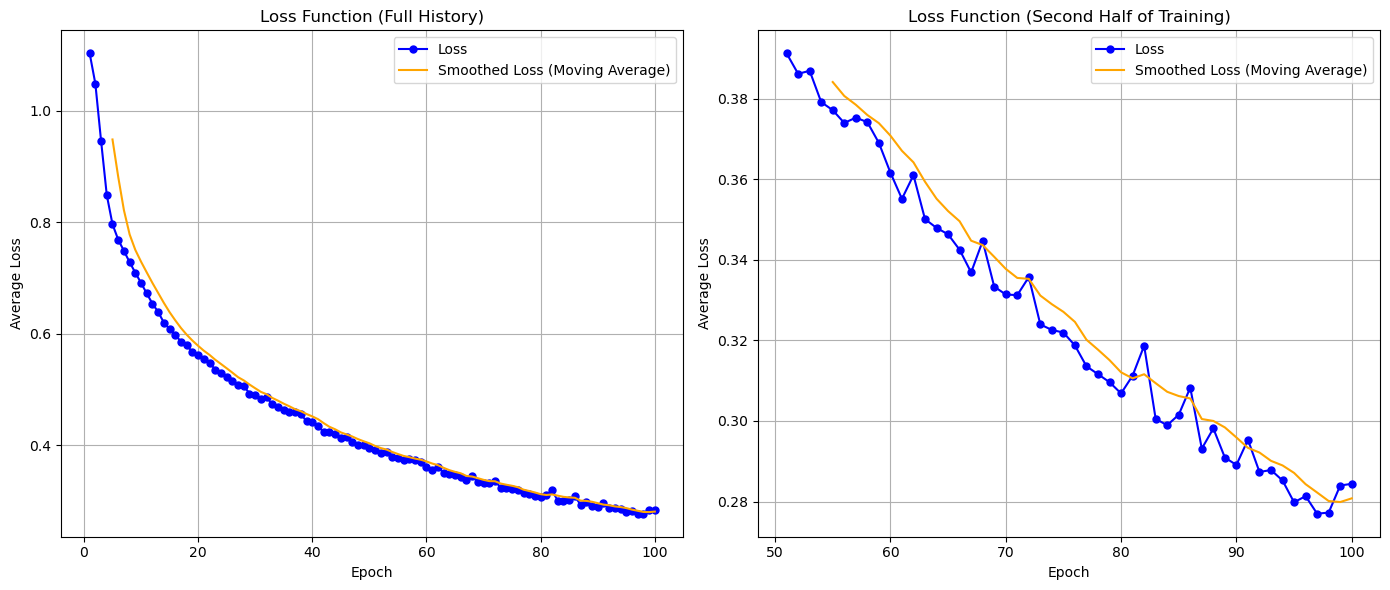

In [16]:
trainer.plot_training_history()

#### Оценка

In [17]:
trainer.evaluate(cifar100)

Classification report for train dataset:
              precision    recall  f1-score   support

    wardrobe     0.9036    0.9000    0.9018       500
  chimpanzee     0.8842    0.8860    0.8851       500
    mushroom     0.9381    0.9400    0.9391       500

    accuracy                         0.9087      1500
   macro avg     0.9087    0.9087    0.9087      1500
weighted avg     0.9087    0.9087    0.9087      1500

--------------------------------------------------
Classification report for test dataset:
              precision    recall  f1-score   support

    wardrobe     0.8899    0.9700    0.9282       100
  chimpanzee     0.9271    0.8900    0.9082       100
    mushroom     0.9789    0.9300    0.9538       100

    accuracy                         0.9300       300
   macro avg     0.9320    0.9300    0.9301       300
weighted avg     0.9320    0.9300    0.9301       300

--------------------------------------------------


#### Сохранение модели в ONNX

In [18]:
trainer.save_model(cifar100)

Model saved as: cifar100_cnn_4_model.onnx


### Эксперимент №2

#### Гиперпараметры

In [19]:
batch_size=2**5
epochs=100
lr_rate=1e-4
dropout_rate=0.25
hidden_layers=[2**4, 2**6, 2**8]

#### Инициализация модели

In [20]:
%%time
trainer = CIFAR100Trainer(classes=CLASSES, batch_size=batch_size, lr_rate=lr_rate, dropout_rate=dropout_rate)

Директория для эксперимента 'cifar100_cnn' инициализирована по пути: logs/cifar100_cnn_5
CPU times: user 178 ms, sys: 356 ms, total: 535 ms
Wall time: 391 ms


In [21]:
%%time
cifar100 = CIFAR100ModelCNN(
    hidden_layers=hidden_layers, 
    dropout_rate=dropout_rate, 
    num_classes=CLASSES.__len__()
)

CPU times: user 19.9 ms, sys: 0 ns, total: 19.9 ms
Wall time: 2.41 ms


In [22]:
trainer.log_model_graph(cifar100)

Граф модели добавлен в лог: logs/cifar100_cnn_5


#### Информация о модели

In [23]:
cifar100.to(device)

CIFAR100ModelCNN(
  (normalize): Normalize()
  (conv_layers): Sequential(
    (0): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(16, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(64, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (classifier_conv): Conv2d(256, 3, kernel_size=(1, 1), stride=(1, 1))
)

In [24]:
summary(cifar100, input_size=(3, 32, 32))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
         Normalize-1            [-1, 3, 32, 32]               0
            Conv2d-2           [-1, 16, 32, 32]             448
              ReLU-3           [-1, 16, 32, 32]               0
         MaxPool2d-4           [-1, 16, 16, 16]               0
            Conv2d-5           [-1, 64, 16, 16]           9,280
              ReLU-6           [-1, 64, 16, 16]               0
         MaxPool2d-7             [-1, 64, 8, 8]               0
            Conv2d-8            [-1, 256, 8, 8]         147,712
              ReLU-9            [-1, 256, 8, 8]               0
        MaxPool2d-10            [-1, 256, 4, 4]               0
           Conv2d-11              [-1, 3, 4, 4]             771
Total params: 158,211
Trainable params: 158,211
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.01
Forward/

#### Обучение

In [25]:
%%time
trainer.train(cifar100, epochs)

Epoch 1/100: 100%|████████████████████| 47/47 [00:00<00:00, 204.50batch/s, loss=0.874061, lr=0.000100]


Epoch: 1/100, Loss: 1.020337


Epoch 2/100: 100%|████████████████████| 47/47 [00:00<00:00, 238.87batch/s, loss=0.845354, lr=0.000100]


Epoch: 2/100, Loss: 0.873376


Epoch 3/100: 100%|████████████████████| 47/47 [00:00<00:00, 216.92batch/s, loss=0.763626, lr=0.000100]


Epoch: 3/100, Loss: 0.786640


Epoch 4/100: 100%|████████████████████| 47/47 [00:00<00:00, 220.79batch/s, loss=0.677815, lr=0.000100]


Epoch: 4/100, Loss: 0.726230


Epoch 5/100: 100%|████████████████████| 47/47 [00:00<00:00, 227.28batch/s, loss=0.639510, lr=0.000100]


Epoch: 5/100, Loss: 0.679361


Epoch 6/100: 100%|████████████████████| 47/47 [00:00<00:00, 197.04batch/s, loss=0.574934, lr=0.000100]


Epoch: 6/100, Loss: 0.639043


Epoch 7/100: 100%|████████████████████| 47/47 [00:00<00:00, 234.49batch/s, loss=0.459051, lr=0.000100]


Epoch: 7/100, Loss: 0.605804


Epoch 8/100: 100%|████████████████████| 47/47 [00:00<00:00, 264.97batch/s, loss=0.504557, lr=0.000100]


Epoch: 8/100, Loss: 0.577757


Epoch 9/100: 100%|████████████████████| 47/47 [00:00<00:00, 240.41batch/s, loss=0.592898, lr=0.000100]


Epoch: 9/100, Loss: 0.562049


Epoch 10/100: 100%|███████████████████| 47/47 [00:00<00:00, 228.51batch/s, loss=0.382294, lr=0.000100]


Epoch: 10/100, Loss: 0.553134


Epoch 11/100: 100%|███████████████████| 47/47 [00:00<00:00, 213.31batch/s, loss=0.686809, lr=0.000100]


Epoch: 11/100, Loss: 0.529735


Epoch 12/100: 100%|███████████████████| 47/47 [00:00<00:00, 224.41batch/s, loss=0.548032, lr=0.000100]


Epoch: 12/100, Loss: 0.509422


Epoch 13/100: 100%|███████████████████| 47/47 [00:00<00:00, 213.49batch/s, loss=0.642000, lr=0.000100]


Epoch: 13/100, Loss: 0.490764


Epoch 14/100: 100%|███████████████████| 47/47 [00:00<00:00, 215.20batch/s, loss=0.424698, lr=0.000100]


Epoch: 14/100, Loss: 0.478168


Epoch 15/100: 100%|███████████████████| 47/47 [00:00<00:00, 220.02batch/s, loss=0.472847, lr=0.000100]


Epoch: 15/100, Loss: 0.468211


Epoch 16/100: 100%|███████████████████| 47/47 [00:00<00:00, 251.75batch/s, loss=0.540554, lr=0.000100]


Epoch: 16/100, Loss: 0.458852


Epoch 17/100: 100%|███████████████████| 47/47 [00:00<00:00, 224.89batch/s, loss=0.502091, lr=0.000100]


Epoch: 17/100, Loss: 0.444191


Epoch 18/100: 100%|███████████████████| 47/47 [00:00<00:00, 241.58batch/s, loss=0.430762, lr=0.000100]


Epoch: 18/100, Loss: 0.428646


Epoch 19/100: 100%|███████████████████| 47/47 [00:00<00:00, 253.18batch/s, loss=0.238509, lr=0.000100]


Epoch: 19/100, Loss: 0.410262


Epoch 20/100: 100%|███████████████████| 47/47 [00:00<00:00, 238.45batch/s, loss=0.446570, lr=0.000100]


Epoch: 20/100, Loss: 0.405245


Epoch 21/100: 100%|███████████████████| 47/47 [00:00<00:00, 187.60batch/s, loss=0.322792, lr=0.000100]


Epoch: 21/100, Loss: 0.392227


Epoch 22/100: 100%|███████████████████| 47/47 [00:00<00:00, 227.16batch/s, loss=0.325965, lr=0.000100]


Epoch: 22/100, Loss: 0.382520


Epoch 23/100: 100%|███████████████████| 47/47 [00:00<00:00, 246.97batch/s, loss=0.341726, lr=0.000100]


Epoch: 23/100, Loss: 0.375314


Epoch 24/100: 100%|███████████████████| 47/47 [00:00<00:00, 244.82batch/s, loss=0.206603, lr=0.000100]


Epoch: 24/100, Loss: 0.368918


Epoch 25/100: 100%|███████████████████| 47/47 [00:00<00:00, 218.91batch/s, loss=0.307619, lr=0.000100]


Epoch: 25/100, Loss: 0.352145


Epoch 26/100: 100%|███████████████████| 47/47 [00:00<00:00, 224.79batch/s, loss=0.371528, lr=0.000100]


Epoch: 26/100, Loss: 0.350213


Epoch 27/100: 100%|███████████████████| 47/47 [00:00<00:00, 233.83batch/s, loss=0.442186, lr=0.000100]


Epoch: 27/100, Loss: 0.348951


Epoch 28/100: 100%|███████████████████| 47/47 [00:00<00:00, 244.34batch/s, loss=0.337031, lr=0.000100]


Epoch: 28/100, Loss: 0.335565


Epoch 29/100: 100%|███████████████████| 47/47 [00:00<00:00, 243.19batch/s, loss=0.371488, lr=0.000100]


Epoch: 29/100, Loss: 0.331286


Epoch 30/100: 100%|███████████████████| 47/47 [00:00<00:00, 241.69batch/s, loss=0.210842, lr=0.000100]


Epoch: 30/100, Loss: 0.317217


Epoch 31/100: 100%|███████████████████| 47/47 [00:00<00:00, 227.73batch/s, loss=0.321734, lr=0.000100]


Epoch: 31/100, Loss: 0.320076


Epoch 32/100: 100%|███████████████████| 47/47 [00:00<00:00, 234.72batch/s, loss=0.250268, lr=0.000100]


Epoch: 32/100, Loss: 0.310296


Epoch 33/100: 100%|███████████████████| 47/47 [00:00<00:00, 224.99batch/s, loss=0.317476, lr=0.000100]


Epoch: 33/100, Loss: 0.309241


Epoch 34/100: 100%|███████████████████| 47/47 [00:00<00:00, 237.29batch/s, loss=0.244584, lr=0.000100]


Epoch: 34/100, Loss: 0.296772


Epoch 35/100: 100%|███████████████████| 47/47 [00:00<00:00, 183.33batch/s, loss=0.271883, lr=0.000100]


Epoch: 35/100, Loss: 0.300762


Epoch 36/100: 100%|███████████████████| 47/47 [00:00<00:00, 194.13batch/s, loss=0.386876, lr=0.000100]


Epoch: 36/100, Loss: 0.290433


Epoch 37/100: 100%|███████████████████| 47/47 [00:00<00:00, 224.80batch/s, loss=0.208014, lr=0.000100]


Epoch: 37/100, Loss: 0.291278


Epoch 38/100: 100%|███████████████████| 47/47 [00:00<00:00, 259.50batch/s, loss=0.304574, lr=0.000100]


Epoch: 38/100, Loss: 0.279551


Epoch 39/100: 100%|███████████████████| 47/47 [00:00<00:00, 246.00batch/s, loss=0.459272, lr=0.000100]


Epoch: 39/100, Loss: 0.270515


Epoch 40/100: 100%|███████████████████| 47/47 [00:00<00:00, 253.09batch/s, loss=0.430764, lr=0.000100]


Epoch: 40/100, Loss: 0.272588


Epoch 41/100: 100%|███████████████████| 47/47 [00:00<00:00, 240.01batch/s, loss=0.307160, lr=0.000100]


Epoch: 41/100, Loss: 0.274654


Epoch 42/100: 100%|███████████████████| 47/47 [00:00<00:00, 236.35batch/s, loss=0.192952, lr=0.000100]


Epoch: 42/100, Loss: 0.256194


Epoch 43/100: 100%|███████████████████| 47/47 [00:00<00:00, 243.55batch/s, loss=0.207144, lr=0.000100]


Epoch: 43/100, Loss: 0.253347


Epoch 44/100: 100%|███████████████████| 47/47 [00:00<00:00, 219.98batch/s, loss=0.331714, lr=0.000100]


Epoch: 44/100, Loss: 0.254001


Epoch 45/100: 100%|███████████████████| 47/47 [00:00<00:00, 237.94batch/s, loss=0.265910, lr=0.000100]


Epoch: 45/100, Loss: 0.255804


Epoch 46/100: 100%|███████████████████| 47/47 [00:00<00:00, 236.68batch/s, loss=0.274453, lr=0.000100]


Epoch: 46/100, Loss: 0.253647


Epoch 47/100: 100%|███████████████████| 47/47 [00:00<00:00, 250.58batch/s, loss=0.205212, lr=0.000090]


Epoch: 47/100, Loss: 0.248088


Epoch 48/100: 100%|███████████████████| 47/47 [00:00<00:00, 195.78batch/s, loss=0.318829, lr=0.000090]


Epoch: 48/100, Loss: 0.243639


Epoch 49/100: 100%|███████████████████| 47/47 [00:00<00:00, 226.20batch/s, loss=0.400159, lr=0.000090]


Epoch: 49/100, Loss: 0.237716


Epoch 50/100: 100%|███████████████████| 47/47 [00:00<00:00, 245.25batch/s, loss=0.175199, lr=0.000090]


Epoch: 50/100, Loss: 0.233926


Epoch 51/100: 100%|███████████████████| 47/47 [00:00<00:00, 229.48batch/s, loss=0.233586, lr=0.000090]


Epoch: 51/100, Loss: 0.227151


Epoch 52/100: 100%|███████████████████| 47/47 [00:00<00:00, 243.33batch/s, loss=0.149557, lr=0.000090]


Epoch: 52/100, Loss: 0.224731


Epoch 53/100: 100%|███████████████████| 47/47 [00:00<00:00, 224.23batch/s, loss=0.282626, lr=0.000090]


Epoch: 53/100, Loss: 0.225209


Epoch 54/100: 100%|███████████████████| 47/47 [00:00<00:00, 235.42batch/s, loss=0.344413, lr=0.000090]


Epoch: 54/100, Loss: 0.219918


Epoch 55/100: 100%|███████████████████| 47/47 [00:00<00:00, 247.78batch/s, loss=0.278397, lr=0.000090]


Epoch: 55/100, Loss: 0.213279


Epoch 56/100: 100%|███████████████████| 47/47 [00:00<00:00, 220.01batch/s, loss=0.138475, lr=0.000090]


Epoch: 56/100, Loss: 0.220900


Epoch 57/100: 100%|███████████████████| 47/47 [00:00<00:00, 222.77batch/s, loss=0.250182, lr=0.000090]


Epoch: 57/100, Loss: 0.210499


Epoch 58/100: 100%|███████████████████| 47/47 [00:00<00:00, 227.13batch/s, loss=0.189841, lr=0.000090]


Epoch: 58/100, Loss: 0.207921


Epoch 59/100: 100%|███████████████████| 47/47 [00:00<00:00, 236.28batch/s, loss=0.417538, lr=0.000090]


Epoch: 59/100, Loss: 0.211781


Epoch 60/100: 100%|███████████████████| 47/47 [00:00<00:00, 237.65batch/s, loss=0.212962, lr=0.000090]


Epoch: 60/100, Loss: 0.200749


Epoch 61/100: 100%|███████████████████| 47/47 [00:00<00:00, 190.74batch/s, loss=0.126374, lr=0.000090]


Epoch: 61/100, Loss: 0.196844


Epoch 62/100: 100%|███████████████████| 47/47 [00:00<00:00, 231.85batch/s, loss=0.322817, lr=0.000090]


Epoch: 62/100, Loss: 0.192868


Epoch 63/100: 100%|███████████████████| 47/47 [00:00<00:00, 233.61batch/s, loss=0.176016, lr=0.000090]


Epoch: 63/100, Loss: 0.192174


Epoch 64/100: 100%|███████████████████| 47/47 [00:00<00:00, 234.08batch/s, loss=0.131320, lr=0.000090]


Epoch: 64/100, Loss: 0.189371


Epoch 65/100: 100%|███████████████████| 47/47 [00:00<00:00, 235.26batch/s, loss=0.197189, lr=0.000090]


Epoch: 65/100, Loss: 0.195211


Epoch 66/100: 100%|███████████████████| 47/47 [00:00<00:00, 246.32batch/s, loss=0.149307, lr=0.000090]


Epoch: 66/100, Loss: 0.184705


Epoch 67/100: 100%|███████████████████| 47/47 [00:00<00:00, 245.44batch/s, loss=0.128655, lr=0.000090]


Epoch: 67/100, Loss: 0.188577


Epoch 68/100: 100%|███████████████████| 47/47 [00:00<00:00, 264.87batch/s, loss=0.135285, lr=0.000090]


Epoch: 68/100, Loss: 0.193568


Epoch 69/100: 100%|███████████████████| 47/47 [00:00<00:00, 242.57batch/s, loss=0.192259, lr=0.000090]


Epoch: 69/100, Loss: 0.200190


Epoch 70/100: 100%|███████████████████| 47/47 [00:00<00:00, 226.27batch/s, loss=0.224733, lr=0.000081]


Epoch: 70/100, Loss: 0.182367


Epoch 71/100: 100%|███████████████████| 47/47 [00:00<00:00, 223.07batch/s, loss=0.286643, lr=0.000081]


Epoch: 71/100, Loss: 0.174444


Epoch 72/100: 100%|███████████████████| 47/47 [00:00<00:00, 256.29batch/s, loss=0.071309, lr=0.000081]


Epoch: 72/100, Loss: 0.174934


Epoch 73/100: 100%|███████████████████| 47/47 [00:00<00:00, 242.35batch/s, loss=0.074050, lr=0.000081]


Epoch: 73/100, Loss: 0.173688


Epoch 74/100: 100%|███████████████████| 47/47 [00:00<00:00, 239.34batch/s, loss=0.122224, lr=0.000081]


Epoch: 74/100, Loss: 0.167813


Epoch 75/100: 100%|███████████████████| 47/47 [00:00<00:00, 257.45batch/s, loss=0.091532, lr=0.000081]


Epoch: 75/100, Loss: 0.166390


Epoch 76/100: 100%|███████████████████| 47/47 [00:00<00:00, 232.40batch/s, loss=0.155048, lr=0.000081]


Epoch: 76/100, Loss: 0.175089


Epoch 77/100: 100%|███████████████████| 47/47 [00:00<00:00, 184.71batch/s, loss=0.111707, lr=0.000081]


Epoch: 77/100, Loss: 0.166933


Epoch 78/100: 100%|███████████████████| 47/47 [00:00<00:00, 228.04batch/s, loss=0.157284, lr=0.000081]


Epoch: 78/100, Loss: 0.167176


Epoch 79/100: 100%|███████████████████| 47/47 [00:00<00:00, 228.14batch/s, loss=0.093997, lr=0.000073]


Epoch: 79/100, Loss: 0.172517


Epoch 80/100: 100%|███████████████████| 47/47 [00:00<00:00, 216.58batch/s, loss=0.201353, lr=0.000073]


Epoch: 80/100, Loss: 0.161928


Epoch 81/100: 100%|███████████████████| 47/47 [00:00<00:00, 220.76batch/s, loss=0.052514, lr=0.000073]


Epoch: 81/100, Loss: 0.167340


Epoch 82/100: 100%|███████████████████| 47/47 [00:00<00:00, 242.64batch/s, loss=0.103105, lr=0.000073]


Epoch: 82/100, Loss: 0.157700


Epoch 83/100: 100%|███████████████████| 47/47 [00:00<00:00, 238.28batch/s, loss=0.168958, lr=0.000073]


Epoch: 83/100, Loss: 0.157357


Epoch 84/100: 100%|███████████████████| 47/47 [00:00<00:00, 216.00batch/s, loss=0.034496, lr=0.000073]


Epoch: 84/100, Loss: 0.157068


Epoch 85/100: 100%|███████████████████| 47/47 [00:00<00:00, 222.62batch/s, loss=0.392922, lr=0.000073]


Epoch: 85/100, Loss: 0.152881


Epoch 86/100: 100%|███████████████████| 47/47 [00:00<00:00, 227.45batch/s, loss=0.033260, lr=0.000073]


Epoch: 86/100, Loss: 0.154496


Epoch 87/100: 100%|███████████████████| 47/47 [00:00<00:00, 216.87batch/s, loss=0.076479, lr=0.000073]


Epoch: 87/100, Loss: 0.152229


Epoch 88/100: 100%|███████████████████| 47/47 [00:00<00:00, 233.72batch/s, loss=0.069271, lr=0.000073]


Epoch: 88/100, Loss: 0.152605


Epoch 89/100: 100%|███████████████████| 47/47 [00:00<00:00, 221.85batch/s, loss=0.126491, lr=0.000073]


Epoch: 89/100, Loss: 0.151276


Epoch 90/100: 100%|███████████████████| 47/47 [00:00<00:00, 225.51batch/s, loss=0.127573, lr=0.000073]


Epoch: 90/100, Loss: 0.149939


Epoch 91/100: 100%|███████████████████| 47/47 [00:00<00:00, 218.97batch/s, loss=0.062974, lr=0.000073]


Epoch: 91/100, Loss: 0.146561


Epoch 92/100: 100%|███████████████████| 47/47 [00:00<00:00, 238.56batch/s, loss=0.199234, lr=0.000073]


Epoch: 92/100, Loss: 0.149379


Epoch 93/100: 100%|███████████████████| 47/47 [00:00<00:00, 215.15batch/s, loss=0.116721, lr=0.000073]


Epoch: 93/100, Loss: 0.147294


Epoch 94/100: 100%|███████████████████| 47/47 [00:00<00:00, 212.51batch/s, loss=0.238381, lr=0.000073]


Epoch: 94/100, Loss: 0.142910


Epoch 95/100: 100%|███████████████████| 47/47 [00:00<00:00, 187.96batch/s, loss=0.054454, lr=0.000073]


Epoch: 95/100, Loss: 0.137705


Epoch 96/100: 100%|███████████████████| 47/47 [00:00<00:00, 231.35batch/s, loss=0.093193, lr=0.000073]


Epoch: 96/100, Loss: 0.139336


Epoch 97/100: 100%|███████████████████| 47/47 [00:00<00:00, 218.48batch/s, loss=0.084505, lr=0.000073]


Epoch: 97/100, Loss: 0.139817


Epoch 98/100: 100%|███████████████████| 47/47 [00:00<00:00, 220.50batch/s, loss=0.100953, lr=0.000073]


Epoch: 98/100, Loss: 0.143299


Epoch 99/100: 100%|███████████████████| 47/47 [00:00<00:00, 230.45batch/s, loss=0.096117, lr=0.000066]


Epoch: 99/100, Loss: 0.139429


Epoch 100/100: 100%|██████████████████| 47/47 [00:00<00:00, 244.43batch/s, loss=0.298758, lr=0.000066]


Epoch: 100/100, Loss: 0.147434
CPU times: user 21.1 s, sys: 2.23 s, total: 23.3 s
Wall time: 20.8 s


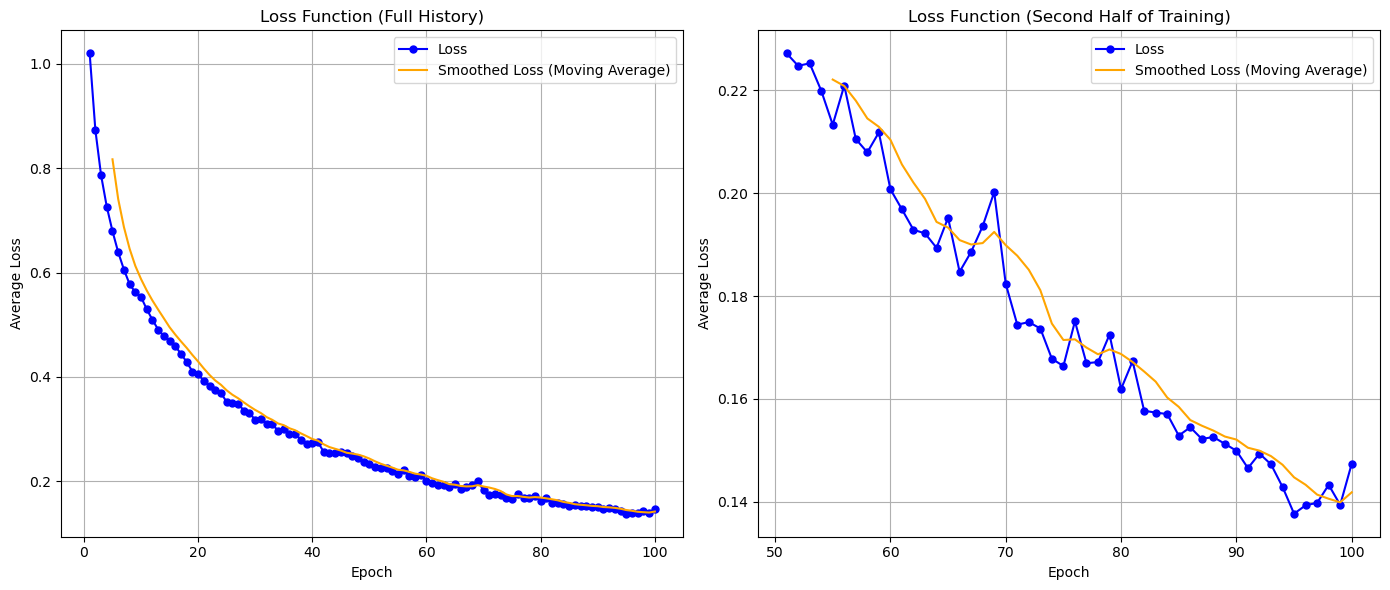

In [26]:
trainer.plot_training_history()

#### Оценка

In [27]:
trainer.evaluate(cifar100)

Classification report for train dataset:
              precision    recall  f1-score   support

    wardrobe     0.9417    0.9700    0.9557       500
  chimpanzee     0.9691    0.9420    0.9554       500
    mushroom     0.9760    0.9740    0.9750       500

    accuracy                         0.9620      1500
   macro avg     0.9623    0.9620    0.9620      1500
weighted avg     0.9623    0.9620    0.9620      1500

--------------------------------------------------
Classification report for test dataset:
              precision    recall  f1-score   support

    wardrobe     0.9333    0.9800    0.9561       100
  chimpanzee     0.9490    0.9300    0.9394       100
    mushroom     0.9897    0.9600    0.9746       100

    accuracy                         0.9567       300
   macro avg     0.9573    0.9567    0.9567       300
weighted avg     0.9573    0.9567    0.9567       300

--------------------------------------------------


#### Сохранение модели в ONNX

In [28]:
trainer.save_model(cifar100)

Model saved as: cifar100_cnn_5_model.onnx


### Эксперимент №3

#### Гиперпараметры

In [29]:
batch_size=2**5
epochs=100
lr_rate=1e-4
dropout_rate=0.15
hidden_layers=[2**6, 2**8, 2**10]

#### Инициализация модели

In [30]:
%%time
trainer = CIFAR100Trainer(classes=CLASSES, batch_size=batch_size, lr_rate=lr_rate, dropout_rate=dropout_rate)

Директория для эксперимента 'cifar100_cnn' инициализирована по пути: logs/cifar100_cnn_6
CPU times: user 157 ms, sys: 361 ms, total: 518 ms
Wall time: 391 ms


In [31]:
%%time
cifar100 = CIFAR100ModelCNN(
    hidden_layers=hidden_layers, 
    dropout_rate=dropout_rate, 
    num_classes=CLASSES.__len__()
)

CPU times: user 76.1 ms, sys: 12 ms, total: 88.1 ms
Wall time: 10.9 ms


In [32]:
trainer.log_model_graph(cifar100)

Граф модели добавлен в лог: logs/cifar100_cnn_6


#### Информация о модели

In [33]:
cifar100.to(device)

CIFAR100ModelCNN(
  (normalize): Normalize()
  (conv_layers): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(256, 1024, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (classifier_conv): Conv2d(1024, 3, kernel_size=(1, 1), stride=(1, 1))
)

In [34]:
summary(cifar100, input_size=(3, 32, 32))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
         Normalize-1            [-1, 3, 32, 32]               0
            Conv2d-2           [-1, 64, 32, 32]           1,792
              ReLU-3           [-1, 64, 32, 32]               0
         MaxPool2d-4           [-1, 64, 16, 16]               0
            Conv2d-5          [-1, 256, 16, 16]         147,712
              ReLU-6          [-1, 256, 16, 16]               0
         MaxPool2d-7            [-1, 256, 8, 8]               0
            Conv2d-8           [-1, 1024, 8, 8]       2,360,320
              ReLU-9           [-1, 1024, 8, 8]               0
        MaxPool2d-10           [-1, 1024, 4, 4]               0
           Conv2d-11              [-1, 3, 4, 4]           3,075
Total params: 2,512,899
Trainable params: 2,512,899
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.01
Forw

In [35]:
summary(cifar100, input_size=(3, 32, 32))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
         Normalize-1            [-1, 3, 32, 32]               0
            Conv2d-2           [-1, 64, 32, 32]           1,792
              ReLU-3           [-1, 64, 32, 32]               0
         MaxPool2d-4           [-1, 64, 16, 16]               0
            Conv2d-5          [-1, 256, 16, 16]         147,712
              ReLU-6          [-1, 256, 16, 16]               0
         MaxPool2d-7            [-1, 256, 8, 8]               0
            Conv2d-8           [-1, 1024, 8, 8]       2,360,320
              ReLU-9           [-1, 1024, 8, 8]               0
        MaxPool2d-10           [-1, 1024, 4, 4]               0
           Conv2d-11              [-1, 3, 4, 4]           3,075
Total params: 2,512,899
Trainable params: 2,512,899
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.01
Forw

#### Обучение

In [36]:
%%time
trainer.train(cifar100, epochs)

Epoch 1/100: 100%|█████████████████████| 47/47 [00:00<00:00, 79.32batch/s, loss=0.498420, lr=0.000100]


Epoch: 1/100, Loss: 0.841447


Epoch 2/100: 100%|█████████████████████| 47/47 [00:00<00:00, 78.55batch/s, loss=0.537094, lr=0.000100]


Epoch: 2/100, Loss: 0.635848


Epoch 3/100: 100%|█████████████████████| 47/47 [00:00<00:00, 76.12batch/s, loss=0.547027, lr=0.000100]


Epoch: 3/100, Loss: 0.576160


Epoch 4/100: 100%|█████████████████████| 47/47 [00:00<00:00, 77.44batch/s, loss=0.458650, lr=0.000100]


Epoch: 4/100, Loss: 0.499660


Epoch 5/100: 100%|█████████████████████| 47/47 [00:00<00:00, 78.15batch/s, loss=0.291784, lr=0.000100]


Epoch: 5/100, Loss: 0.456742


Epoch 6/100: 100%|█████████████████████| 47/47 [00:00<00:00, 78.93batch/s, loss=0.335426, lr=0.000100]


Epoch: 6/100, Loss: 0.412672


Epoch 7/100: 100%|█████████████████████| 47/47 [00:00<00:00, 78.55batch/s, loss=0.378051, lr=0.000100]


Epoch: 7/100, Loss: 0.370559


Epoch 8/100: 100%|█████████████████████| 47/47 [00:00<00:00, 79.34batch/s, loss=0.205465, lr=0.000100]


Epoch: 8/100, Loss: 0.350833


Epoch 9/100: 100%|█████████████████████| 47/47 [00:00<00:00, 76.21batch/s, loss=0.351821, lr=0.000100]


Epoch: 9/100, Loss: 0.342758


Epoch 10/100: 100%|████████████████████| 47/47 [00:00<00:00, 78.57batch/s, loss=0.278700, lr=0.000100]


Epoch: 10/100, Loss: 0.315263


Epoch 11/100: 100%|████████████████████| 47/47 [00:00<00:00, 78.41batch/s, loss=0.186067, lr=0.000100]


Epoch: 11/100, Loss: 0.329171


Epoch 12/100: 100%|████████████████████| 47/47 [00:00<00:00, 79.07batch/s, loss=0.339322, lr=0.000100]


Epoch: 12/100, Loss: 0.287696


Epoch 13/100: 100%|████████████████████| 47/47 [00:00<00:00, 76.93batch/s, loss=0.376376, lr=0.000100]


Epoch: 13/100, Loss: 0.284743


Epoch 14/100: 100%|████████████████████| 47/47 [00:00<00:00, 76.26batch/s, loss=0.302236, lr=0.000100]


Epoch: 14/100, Loss: 0.247712


Epoch 15/100: 100%|████████████████████| 47/47 [00:00<00:00, 77.26batch/s, loss=0.200891, lr=0.000100]


Epoch: 15/100, Loss: 0.247408


Epoch 16/100: 100%|████████████████████| 47/47 [00:00<00:00, 76.95batch/s, loss=0.223546, lr=0.000100]


Epoch: 16/100, Loss: 0.231174


Epoch 17/100: 100%|████████████████████| 47/47 [00:00<00:00, 77.42batch/s, loss=0.229671, lr=0.000100]


Epoch: 17/100, Loss: 0.215998


Epoch 18/100: 100%|████████████████████| 47/47 [00:00<00:00, 76.64batch/s, loss=0.172093, lr=0.000100]


Epoch: 18/100, Loss: 0.222027


Epoch 19/100: 100%|████████████████████| 47/47 [00:00<00:00, 77.95batch/s, loss=0.220879, lr=0.000100]


Epoch: 19/100, Loss: 0.213829


Epoch 20/100: 100%|████████████████████| 47/47 [00:00<00:00, 77.75batch/s, loss=0.203819, lr=0.000100]


Epoch: 20/100, Loss: 0.195540


Epoch 21/100: 100%|████████████████████| 47/47 [00:00<00:00, 77.44batch/s, loss=0.126947, lr=0.000100]


Epoch: 21/100, Loss: 0.199345


Epoch 22/100: 100%|████████████████████| 47/47 [00:00<00:00, 76.46batch/s, loss=0.152825, lr=0.000100]


Epoch: 22/100, Loss: 0.192028


Epoch 23/100: 100%|████████████████████| 47/47 [00:00<00:00, 76.34batch/s, loss=0.238137, lr=0.000100]


Epoch: 23/100, Loss: 0.157275


Epoch 24/100: 100%|████████████████████| 47/47 [00:00<00:00, 76.33batch/s, loss=0.236279, lr=0.000100]


Epoch: 24/100, Loss: 0.157070


Epoch 25/100: 100%|████████████████████| 47/47 [00:00<00:00, 75.01batch/s, loss=0.149898, lr=0.000100]


Epoch: 25/100, Loss: 0.150975


Epoch 26/100: 100%|████████████████████| 47/47 [00:00<00:00, 77.65batch/s, loss=0.307251, lr=0.000100]


Epoch: 26/100, Loss: 0.171380


Epoch 27/100: 100%|████████████████████| 47/47 [00:00<00:00, 77.34batch/s, loss=0.150653, lr=0.000100]


Epoch: 27/100, Loss: 0.167803


Epoch 28/100: 100%|████████████████████| 47/47 [00:00<00:00, 77.64batch/s, loss=0.054071, lr=0.000100]


Epoch: 28/100, Loss: 0.141452


Epoch 29/100: 100%|████████████████████| 47/47 [00:00<00:00, 77.44batch/s, loss=0.155360, lr=0.000100]


Epoch: 29/100, Loss: 0.177209


Epoch 30/100: 100%|████████████████████| 47/47 [00:00<00:00, 77.09batch/s, loss=0.198354, lr=0.000100]


Epoch: 30/100, Loss: 0.124570


Epoch 31/100: 100%|████████████████████| 47/47 [00:00<00:00, 79.82batch/s, loss=0.051720, lr=0.000100]


Epoch: 31/100, Loss: 0.128512


Epoch 32/100: 100%|████████████████████| 47/47 [00:00<00:00, 80.15batch/s, loss=0.041182, lr=0.000100]


Epoch: 32/100, Loss: 0.139140


Epoch 33/100: 100%|████████████████████| 47/47 [00:00<00:00, 78.16batch/s, loss=0.061540, lr=0.000100]


Epoch: 33/100, Loss: 0.120030


Epoch 34/100: 100%|████████████████████| 47/47 [00:00<00:00, 78.15batch/s, loss=0.211902, lr=0.000100]


Epoch: 34/100, Loss: 0.112589


Epoch 35/100: 100%|████████████████████| 47/47 [00:00<00:00, 77.55batch/s, loss=0.104173, lr=0.000100]


Epoch: 35/100, Loss: 0.102151


Epoch 36/100: 100%|████████████████████| 47/47 [00:00<00:00, 79.24batch/s, loss=0.069361, lr=0.000100]


Epoch: 36/100, Loss: 0.096696


Epoch 37/100: 100%|████████████████████| 47/47 [00:00<00:00, 79.65batch/s, loss=0.096521, lr=0.000100]


Epoch: 37/100, Loss: 0.120553


Epoch 38/100: 100%|████████████████████| 47/47 [00:00<00:00, 79.44batch/s, loss=0.085069, lr=0.000100]


Epoch: 38/100, Loss: 0.112414


Epoch 39/100: 100%|████████████████████| 47/47 [00:00<00:00, 77.56batch/s, loss=0.093553, lr=0.000100]


Epoch: 39/100, Loss: 0.091853


Epoch 40/100: 100%|████████████████████| 47/47 [00:00<00:00, 77.46batch/s, loss=0.073904, lr=0.000100]


Epoch: 40/100, Loss: 0.095652


Epoch 41/100: 100%|████████████████████| 47/47 [00:00<00:00, 77.40batch/s, loss=0.064387, lr=0.000100]


Epoch: 41/100, Loss: 0.095271


Epoch 42/100: 100%|████████████████████| 47/47 [00:00<00:00, 77.98batch/s, loss=0.151461, lr=0.000100]


Epoch: 42/100, Loss: 0.098207


Epoch 43/100: 100%|████████████████████| 47/47 [00:00<00:00, 79.99batch/s, loss=0.038203, lr=0.000090]


Epoch: 43/100, Loss: 0.096570


Epoch 44/100: 100%|████████████████████| 47/47 [00:00<00:00, 80.35batch/s, loss=0.083409, lr=0.000090]


Epoch: 44/100, Loss: 0.079045


Epoch 45/100: 100%|████████████████████| 47/47 [00:00<00:00, 77.55batch/s, loss=0.108570, lr=0.000090]


Epoch: 45/100, Loss: 0.086574


Epoch 46/100: 100%|████████████████████| 47/47 [00:00<00:00, 77.61batch/s, loss=0.067722, lr=0.000090]


Epoch: 46/100, Loss: 0.097237


Epoch 47/100: 100%|████████████████████| 47/47 [00:00<00:00, 79.45batch/s, loss=0.057388, lr=0.000090]


Epoch: 47/100, Loss: 0.075890


Epoch 48/100: 100%|████████████████████| 47/47 [00:00<00:00, 77.94batch/s, loss=0.059423, lr=0.000090]


Epoch: 48/100, Loss: 0.083054


Epoch 49/100: 100%|████████████████████| 47/47 [00:00<00:00, 77.16batch/s, loss=0.043640, lr=0.000090]


Epoch: 49/100, Loss: 0.063441


Epoch 50/100: 100%|████████████████████| 47/47 [00:00<00:00, 76.84batch/s, loss=0.163081, lr=0.000090]


Epoch: 50/100, Loss: 0.103418


Epoch 51/100: 100%|████████████████████| 47/47 [00:00<00:00, 77.23batch/s, loss=0.089778, lr=0.000090]


Epoch: 51/100, Loss: 0.072979


Epoch 52/100: 100%|████████████████████| 47/47 [00:00<00:00, 78.95batch/s, loss=0.048018, lr=0.000090]


Epoch: 52/100, Loss: 0.066325


Epoch 53/100: 100%|████████████████████| 47/47 [00:00<00:00, 77.78batch/s, loss=0.027235, lr=0.000081]


Epoch: 53/100, Loss: 0.059154


Epoch 54/100: 100%|████████████████████| 47/47 [00:00<00:00, 77.09batch/s, loss=0.075985, lr=0.000081]


Epoch: 54/100, Loss: 0.068500


Epoch 55/100: 100%|████████████████████| 47/47 [00:00<00:00, 79.25batch/s, loss=0.010091, lr=0.000081]


Epoch: 55/100, Loss: 0.073319


Epoch 56/100: 100%|████████████████████| 47/47 [00:00<00:00, 80.12batch/s, loss=0.035079, lr=0.000081]


Epoch: 56/100, Loss: 0.053243


Epoch 57/100: 100%|████████████████████| 47/47 [00:00<00:00, 78.41batch/s, loss=0.097255, lr=0.000081]


Epoch: 57/100, Loss: 0.053925


Epoch 58/100: 100%|████████████████████| 47/47 [00:00<00:00, 78.29batch/s, loss=0.102047, lr=0.000081]


Epoch: 58/100, Loss: 0.059744


Epoch 59/100: 100%|████████████████████| 47/47 [00:00<00:00, 79.29batch/s, loss=0.008660, lr=0.000081]


Epoch: 59/100, Loss: 0.052594


Epoch 60/100: 100%|████████████████████| 47/47 [00:00<00:00, 79.88batch/s, loss=0.082257, lr=0.000081]


Epoch: 60/100, Loss: 0.052569


Epoch 61/100: 100%|████████████████████| 47/47 [00:00<00:00, 78.52batch/s, loss=0.165113, lr=0.000081]


Epoch: 61/100, Loss: 0.054020


Epoch 62/100: 100%|████████████████████| 47/47 [00:00<00:00, 78.59batch/s, loss=0.048981, lr=0.000081]


Epoch: 62/100, Loss: 0.045011


Epoch 63/100: 100%|████████████████████| 47/47 [00:00<00:00, 78.93batch/s, loss=0.034978, lr=0.000081]


Epoch: 63/100, Loss: 0.040496


Epoch 64/100: 100%|████████████████████| 47/47 [00:00<00:00, 78.81batch/s, loss=0.139050, lr=0.000081]


Epoch: 64/100, Loss: 0.037852


Epoch 65/100: 100%|████████████████████| 47/47 [00:00<00:00, 79.08batch/s, loss=0.037935, lr=0.000081]


Epoch: 65/100, Loss: 0.049819


Epoch 66/100: 100%|████████████████████| 47/47 [00:00<00:00, 79.60batch/s, loss=0.050652, lr=0.000081]


Epoch: 66/100, Loss: 0.049225


Epoch 67/100: 100%|████████████████████| 47/47 [00:00<00:00, 79.39batch/s, loss=0.039074, lr=0.000081]


Epoch: 67/100, Loss: 0.039041


Epoch 68/100: 100%|████████████████████| 47/47 [00:00<00:00, 78.41batch/s, loss=0.073301, lr=0.000073]


Epoch: 68/100, Loss: 0.035885


Epoch 69/100: 100%|████████████████████| 47/47 [00:00<00:00, 78.87batch/s, loss=0.030784, lr=0.000073]


Epoch: 69/100, Loss: 0.034310


Epoch 70/100: 100%|████████████████████| 47/47 [00:00<00:00, 79.04batch/s, loss=0.048389, lr=0.000073]


Epoch: 70/100, Loss: 0.038217


Epoch 71/100: 100%|████████████████████| 47/47 [00:00<00:00, 79.51batch/s, loss=0.020751, lr=0.000073]


Epoch: 71/100, Loss: 0.040332


Epoch 72/100: 100%|████████████████████| 47/47 [00:00<00:00, 79.58batch/s, loss=0.031837, lr=0.000073]


Epoch: 72/100, Loss: 0.031980


Epoch 73/100: 100%|████████████████████| 47/47 [00:00<00:00, 78.38batch/s, loss=0.004732, lr=0.000073]


Epoch: 73/100, Loss: 0.033956


Epoch 74/100: 100%|████████████████████| 47/47 [00:00<00:00, 80.44batch/s, loss=0.012787, lr=0.000073]


Epoch: 74/100, Loss: 0.038003


Epoch 75/100: 100%|████████████████████| 47/47 [00:00<00:00, 77.22batch/s, loss=0.142879, lr=0.000073]


Epoch: 75/100, Loss: 0.049882


Epoch 76/100: 100%|████████████████████| 47/47 [00:00<00:00, 78.69batch/s, loss=0.119818, lr=0.000066]


Epoch: 76/100, Loss: 0.033934


Epoch 77/100: 100%|████████████████████| 47/47 [00:00<00:00, 78.98batch/s, loss=0.032600, lr=0.000066]


Epoch: 77/100, Loss: 0.040639


Epoch 78/100: 100%|████████████████████| 47/47 [00:00<00:00, 80.31batch/s, loss=0.004386, lr=0.000066]


Epoch: 78/100, Loss: 0.026838


Epoch 79/100: 100%|████████████████████| 47/47 [00:00<00:00, 79.07batch/s, loss=0.022504, lr=0.000066]


Epoch: 79/100, Loss: 0.028600


Epoch 80/100: 100%|████████████████████| 47/47 [00:00<00:00, 78.62batch/s, loss=0.016516, lr=0.000066]


Epoch: 80/100, Loss: 0.022831


Epoch 81/100: 100%|████████████████████| 47/47 [00:00<00:00, 78.25batch/s, loss=0.016396, lr=0.000066]


Epoch: 81/100, Loss: 0.022944


Epoch 82/100: 100%|████████████████████| 47/47 [00:00<00:00, 79.41batch/s, loss=0.016681, lr=0.000066]


Epoch: 82/100, Loss: 0.023897


Epoch 83/100: 100%|████████████████████| 47/47 [00:00<00:00, 78.89batch/s, loss=0.009039, lr=0.000066]


Epoch: 83/100, Loss: 0.024329


Epoch 84/100: 100%|████████████████████| 47/47 [00:00<00:00, 79.43batch/s, loss=0.014264, lr=0.000059]


Epoch: 84/100, Loss: 0.039334


Epoch 85/100: 100%|████████████████████| 47/47 [00:00<00:00, 78.92batch/s, loss=0.085394, lr=0.000059]


Epoch: 85/100, Loss: 0.038563


Epoch 86/100: 100%|████████████████████| 47/47 [00:00<00:00, 78.77batch/s, loss=0.007166, lr=0.000059]


Epoch: 86/100, Loss: 0.020772


Epoch 87/100: 100%|████████████████████| 47/47 [00:00<00:00, 80.01batch/s, loss=0.019477, lr=0.000059]


Epoch: 87/100, Loss: 0.020943


Epoch 88/100: 100%|████████████████████| 47/47 [00:00<00:00, 78.79batch/s, loss=0.024936, lr=0.000059]


Epoch: 88/100, Loss: 0.017698


Epoch 89/100: 100%|████████████████████| 47/47 [00:00<00:00, 78.12batch/s, loss=0.013735, lr=0.000059]


Epoch: 89/100, Loss: 0.023308


Epoch 90/100: 100%|████████████████████| 47/47 [00:00<00:00, 78.56batch/s, loss=0.028284, lr=0.000059]


Epoch: 90/100, Loss: 0.017612


Epoch 91/100: 100%|████████████████████| 47/47 [00:00<00:00, 78.59batch/s, loss=0.015868, lr=0.000059]


Epoch: 91/100, Loss: 0.017771


Epoch 92/100: 100%|████████████████████| 47/47 [00:00<00:00, 79.54batch/s, loss=0.012094, lr=0.000059]


Epoch: 92/100, Loss: 0.016656


Epoch 93/100: 100%|████████████████████| 47/47 [00:00<00:00, 78.46batch/s, loss=0.031177, lr=0.000059]


Epoch: 93/100, Loss: 0.020984


Epoch 94/100: 100%|████████████████████| 47/47 [00:00<00:00, 79.18batch/s, loss=0.011680, lr=0.000059]


Epoch: 94/100, Loss: 0.019471


Epoch 95/100: 100%|████████████████████| 47/47 [00:00<00:00, 78.93batch/s, loss=0.038642, lr=0.000059]


Epoch: 95/100, Loss: 0.026739


Epoch 96/100: 100%|████████████████████| 47/47 [00:00<00:00, 78.80batch/s, loss=0.029061, lr=0.000053]


Epoch: 96/100, Loss: 0.020214


Epoch 97/100: 100%|████████████████████| 47/47 [00:00<00:00, 80.03batch/s, loss=0.006469, lr=0.000053]


Epoch: 97/100, Loss: 0.015986


Epoch 98/100: 100%|████████████████████| 47/47 [00:00<00:00, 79.85batch/s, loss=0.016245, lr=0.000053]


Epoch: 98/100, Loss: 0.015269


Epoch 99/100: 100%|████████████████████| 47/47 [00:00<00:00, 78.91batch/s, loss=0.006827, lr=0.000053]


Epoch: 99/100, Loss: 0.015525


Epoch 100/100: 100%|███████████████████| 47/47 [00:00<00:00, 78.56batch/s, loss=0.048892, lr=0.000053]

Epoch: 100/100, Loss: 0.014475
CPU times: user 28.1 s, sys: 34.9 s, total: 1min 2s
Wall time: 1min


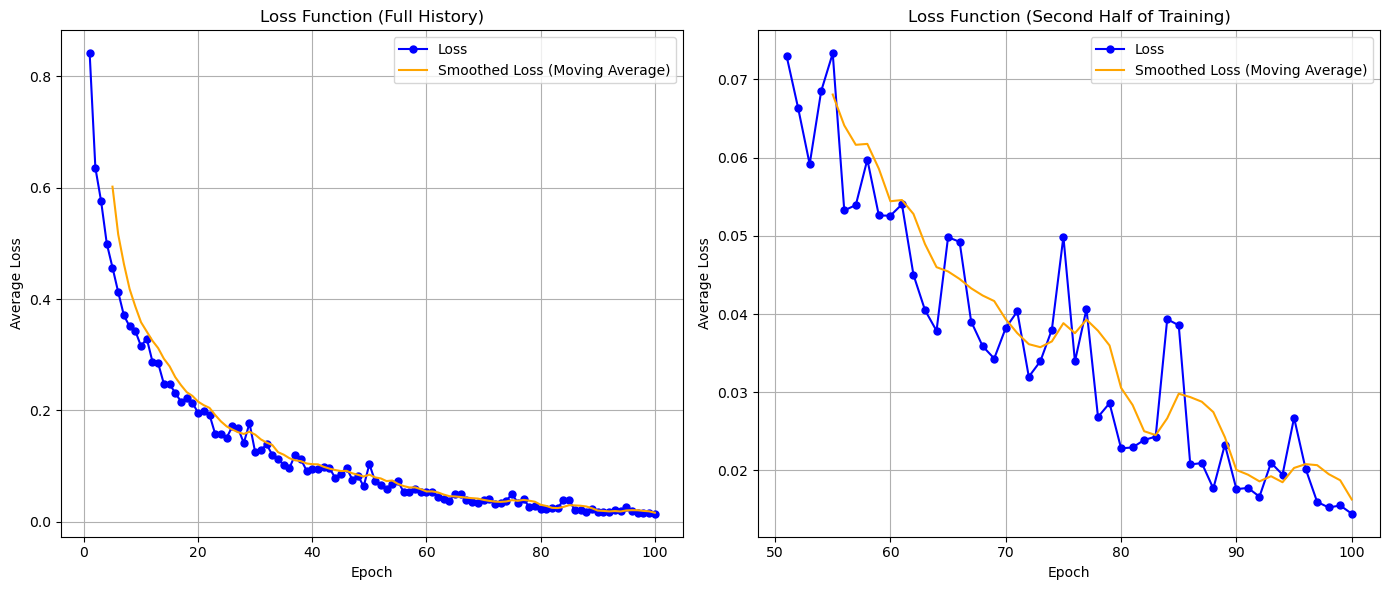

In [37]:
trainer.plot_training_history()

#### Оценка

In [38]:
trainer.evaluate(cifar100)

Classification report for train dataset:
              precision    recall  f1-score   support

    wardrobe     0.9980    0.9940    0.9960       500
  chimpanzee     1.0000    0.9620    0.9806       500
    mushroom     0.9597    1.0000    0.9794       500

    accuracy                         0.9853      1500
   macro avg     0.9859    0.9853    0.9854      1500
weighted avg     0.9859    0.9853    0.9854      1500

--------------------------------------------------
Classification report for test dataset:
              precision    recall  f1-score   support

    wardrobe     0.9423    0.9800    0.9608       100
  chimpanzee     0.9778    0.8800    0.9263       100
    mushroom     0.9245    0.9800    0.9515       100

    accuracy                         0.9467       300
   macro avg     0.9482    0.9467    0.9462       300
weighted avg     0.9482    0.9467    0.9462       300

--------------------------------------------------


#### Сохранение модели в ONNX

In [39]:
trainer.save_model(cifar100)

Model saved as: cifar100_cnn_6_model.onnx


### Эксперимент №4

#### Гиперпараметры

In [40]:
batch_size=2**5
epochs=100
lr_rate = 1e-4
dropout_rate=0.2
hidden_layers=[2**5, 2**6, 2**7, 2**8, 2**9]

#### Инициализация модели

In [41]:
%%time
trainer = CIFAR100Trainer(classes=CLASSES, batch_size=batch_size, lr_rate=lr_rate, dropout_rate=dropout_rate)

Директория для эксперимента 'cifar100_cnn' инициализирована по пути: logs/cifar100_cnn_7
CPU times: user 189 ms, sys: 325 ms, total: 514 ms
Wall time: 361 ms


In [42]:
%%time
cifar100 = CIFAR100ModelCNN(
    hidden_layers=hidden_layers, 
    dropout_rate=dropout_rate, 
    num_classes=CLASSES.__len__()
)

CPU times: user 74 ms, sys: 13.3 ms, total: 87.3 ms
Wall time: 10.8 ms


In [43]:
trainer.log_model_graph(cifar100)

Граф модели добавлен в лог: logs/cifar100_cnn_7


#### Информация о модели

In [44]:
cifar100.to(device)

CIFAR100ModelCNN(
  (normalize): Normalize()
  (conv_layers): Sequential(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (9): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (10): ReLU(inplace=True)
    (11): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (12): Conv2d(256, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1,

In [45]:
summary(cifar100, input_size=(3, 32, 32))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
         Normalize-1            [-1, 3, 32, 32]               0
            Conv2d-2           [-1, 32, 32, 32]             896
              ReLU-3           [-1, 32, 32, 32]               0
         MaxPool2d-4           [-1, 32, 16, 16]               0
            Conv2d-5           [-1, 64, 16, 16]          18,496
              ReLU-6           [-1, 64, 16, 16]               0
         MaxPool2d-7             [-1, 64, 8, 8]               0
            Conv2d-8            [-1, 128, 8, 8]          73,856
              ReLU-9            [-1, 128, 8, 8]               0
        MaxPool2d-10            [-1, 128, 4, 4]               0
           Conv2d-11            [-1, 256, 4, 4]         295,168
             ReLU-12            [-1, 256, 4, 4]               0
        MaxPool2d-13            [-1, 256, 2, 2]               0
           Conv2d-14            [-1, 51

#### Обучение

In [46]:
%%time
trainer.train(cifar100, epochs)

Epoch 1/100: 100%|████████████████████| 47/47 [00:00<00:00, 147.42batch/s, loss=0.707234, lr=0.000100]


Epoch: 1/100, Loss: 0.921994


Epoch 2/100: 100%|████████████████████| 47/47 [00:00<00:00, 166.27batch/s, loss=0.469834, lr=0.000100]


Epoch: 2/100, Loss: 0.613234


Epoch 3/100: 100%|████████████████████| 47/47 [00:00<00:00, 169.68batch/s, loss=0.262210, lr=0.000100]


Epoch: 3/100, Loss: 0.513593


Epoch 4/100: 100%|████████████████████| 47/47 [00:00<00:00, 169.36batch/s, loss=0.372818, lr=0.000100]


Epoch: 4/100, Loss: 0.488289


Epoch 5/100: 100%|████████████████████| 47/47 [00:00<00:00, 167.03batch/s, loss=0.357243, lr=0.000100]


Epoch: 5/100, Loss: 0.424830


Epoch 6/100: 100%|████████████████████| 47/47 [00:00<00:00, 167.07batch/s, loss=0.344055, lr=0.000100]


Epoch: 6/100, Loss: 0.374171


Epoch 7/100: 100%|████████████████████| 47/47 [00:00<00:00, 173.53batch/s, loss=0.579414, lr=0.000100]


Epoch: 7/100, Loss: 0.326901


Epoch 8/100: 100%|████████████████████| 47/47 [00:00<00:00, 162.74batch/s, loss=0.287035, lr=0.000100]


Epoch: 8/100, Loss: 0.286320


Epoch 9/100: 100%|████████████████████| 47/47 [00:00<00:00, 159.28batch/s, loss=0.194197, lr=0.000100]


Epoch: 9/100, Loss: 0.273249


Epoch 10/100: 100%|███████████████████| 47/47 [00:00<00:00, 165.34batch/s, loss=0.365881, lr=0.000100]


Epoch: 10/100, Loss: 0.242878


Epoch 11/100: 100%|███████████████████| 47/47 [00:00<00:00, 172.45batch/s, loss=0.138583, lr=0.000100]


Epoch: 11/100, Loss: 0.218191


Epoch 12/100: 100%|███████████████████| 47/47 [00:00<00:00, 169.65batch/s, loss=0.196811, lr=0.000100]


Epoch: 12/100, Loss: 0.195180


Epoch 13/100: 100%|███████████████████| 47/47 [00:00<00:00, 173.26batch/s, loss=0.199697, lr=0.000100]


Epoch: 13/100, Loss: 0.186145


Epoch 14/100: 100%|███████████████████| 47/47 [00:00<00:00, 168.40batch/s, loss=0.245713, lr=0.000100]


Epoch: 14/100, Loss: 0.174871


Epoch 15/100: 100%|███████████████████| 47/47 [00:00<00:00, 164.74batch/s, loss=0.316941, lr=0.000100]


Epoch: 15/100, Loss: 0.190237


Epoch 16/100: 100%|███████████████████| 47/47 [00:00<00:00, 164.54batch/s, loss=0.187124, lr=0.000100]


Epoch: 16/100, Loss: 0.152099


Epoch 17/100: 100%|███████████████████| 47/47 [00:00<00:00, 145.34batch/s, loss=0.077845, lr=0.000100]


Epoch: 17/100, Loss: 0.130695


Epoch 18/100: 100%|███████████████████| 47/47 [00:00<00:00, 159.63batch/s, loss=0.075196, lr=0.000100]


Epoch: 18/100, Loss: 0.113319


Epoch 19/100: 100%|███████████████████| 47/47 [00:00<00:00, 169.94batch/s, loss=0.075872, lr=0.000100]


Epoch: 19/100, Loss: 0.112196


Epoch 20/100: 100%|███████████████████| 47/47 [00:00<00:00, 153.68batch/s, loss=0.051445, lr=0.000100]


Epoch: 20/100, Loss: 0.097880


Epoch 21/100: 100%|███████████████████| 47/47 [00:00<00:00, 154.97batch/s, loss=0.080806, lr=0.000100]


Epoch: 21/100, Loss: 0.092918


Epoch 22/100: 100%|███████████████████| 47/47 [00:00<00:00, 164.85batch/s, loss=0.084085, lr=0.000100]


Epoch: 22/100, Loss: 0.080445


Epoch 23/100: 100%|███████████████████| 47/47 [00:00<00:00, 168.60batch/s, loss=0.067950, lr=0.000100]


Epoch: 23/100, Loss: 0.077177


Epoch 24/100: 100%|███████████████████| 47/47 [00:00<00:00, 169.92batch/s, loss=0.067015, lr=0.000100]


Epoch: 24/100, Loss: 0.051520


Epoch 25/100: 100%|███████████████████| 47/47 [00:00<00:00, 150.64batch/s, loss=0.167795, lr=0.000100]


Epoch: 25/100, Loss: 0.073811


Epoch 26/100: 100%|███████████████████| 47/47 [00:00<00:00, 169.54batch/s, loss=0.043979, lr=0.000100]


Epoch: 26/100, Loss: 0.079096


Epoch 27/100: 100%|███████████████████| 47/47 [00:00<00:00, 162.27batch/s, loss=0.079381, lr=0.000100]


Epoch: 27/100, Loss: 0.040668


Epoch 28/100: 100%|███████████████████| 47/47 [00:00<00:00, 169.52batch/s, loss=0.066958, lr=0.000100]


Epoch: 28/100, Loss: 0.050324


Epoch 29/100: 100%|███████████████████| 47/47 [00:00<00:00, 169.58batch/s, loss=0.026680, lr=0.000100]


Epoch: 29/100, Loss: 0.044907


Epoch 30/100: 100%|███████████████████| 47/47 [00:00<00:00, 167.52batch/s, loss=0.006747, lr=0.000100]


Epoch: 30/100, Loss: 0.024415


Epoch 31/100: 100%|███████████████████| 47/47 [00:00<00:00, 166.66batch/s, loss=0.012300, lr=0.000100]


Epoch: 31/100, Loss: 0.020131


Epoch 32/100: 100%|███████████████████| 47/47 [00:00<00:00, 174.18batch/s, loss=0.006427, lr=0.000100]


Epoch: 32/100, Loss: 0.017884


Epoch 33/100: 100%|███████████████████| 47/47 [00:00<00:00, 172.88batch/s, loss=0.044447, lr=0.000100]


Epoch: 33/100, Loss: 0.013969


Epoch 34/100: 100%|███████████████████| 47/47 [00:00<00:00, 166.10batch/s, loss=0.007380, lr=0.000100]


Epoch: 34/100, Loss: 0.013281


Epoch 35/100: 100%|███████████████████| 47/47 [00:00<00:00, 167.36batch/s, loss=0.007886, lr=0.000100]


Epoch: 35/100, Loss: 0.010454


Epoch 36/100: 100%|███████████████████| 47/47 [00:00<00:00, 165.82batch/s, loss=0.004495, lr=0.000100]


Epoch: 36/100, Loss: 0.011062


Epoch 37/100: 100%|███████████████████| 47/47 [00:00<00:00, 168.32batch/s, loss=0.005568, lr=0.000100]


Epoch: 37/100, Loss: 0.010422


Epoch 38/100: 100%|███████████████████| 47/47 [00:00<00:00, 170.71batch/s, loss=0.002254, lr=0.000100]


Epoch: 38/100, Loss: 0.008081


Epoch 39/100: 100%|███████████████████| 47/47 [00:00<00:00, 167.27batch/s, loss=0.006312, lr=0.000100]


Epoch: 39/100, Loss: 0.006287


Epoch 40/100: 100%|███████████████████| 47/47 [00:00<00:00, 170.20batch/s, loss=0.005416, lr=0.000100]


Epoch: 40/100, Loss: 0.005214


Epoch 41/100: 100%|███████████████████| 47/47 [00:00<00:00, 174.23batch/s, loss=0.014891, lr=0.000100]


Epoch: 41/100, Loss: 0.012229


Epoch 42/100: 100%|███████████████████| 47/47 [00:00<00:00, 165.95batch/s, loss=0.455868, lr=0.000100]


Epoch: 42/100, Loss: 0.081266


Epoch 43/100: 100%|███████████████████| 47/47 [00:00<00:00, 164.65batch/s, loss=0.048397, lr=0.000100]


Epoch: 43/100, Loss: 0.104790


Epoch 44/100: 100%|███████████████████| 47/47 [00:00<00:00, 166.49batch/s, loss=0.021343, lr=0.000090]


Epoch: 44/100, Loss: 0.019129


Epoch 45/100: 100%|███████████████████| 47/47 [00:00<00:00, 169.95batch/s, loss=0.005344, lr=0.000090]


Epoch: 45/100, Loss: 0.010421


Epoch 46/100: 100%|███████████████████| 47/47 [00:00<00:00, 166.59batch/s, loss=0.005336, lr=0.000090]


Epoch: 46/100, Loss: 0.007037


Epoch 47/100: 100%|███████████████████| 47/47 [00:00<00:00, 156.23batch/s, loss=0.004035, lr=0.000081]


Epoch: 47/100, Loss: 0.005966


Epoch 48/100: 100%|███████████████████| 47/47 [00:00<00:00, 161.56batch/s, loss=0.005721, lr=0.000081]


Epoch: 48/100, Loss: 0.004702


Epoch 49/100: 100%|███████████████████| 47/47 [00:00<00:00, 157.87batch/s, loss=0.007541, lr=0.000081]


Epoch: 49/100, Loss: 0.004171


Epoch 50/100: 100%|███████████████████| 47/47 [00:00<00:00, 165.91batch/s, loss=0.002976, lr=0.000081]


Epoch: 50/100, Loss: 0.003754


Epoch 51/100: 100%|███████████████████| 47/47 [00:00<00:00, 164.50batch/s, loss=0.000977, lr=0.000081]


Epoch: 51/100, Loss: 0.003270


Epoch 52/100: 100%|███████████████████| 47/47 [00:00<00:00, 169.41batch/s, loss=0.001091, lr=0.000081]


Epoch: 52/100, Loss: 0.002985


Epoch 53/100: 100%|███████████████████| 47/47 [00:00<00:00, 161.46batch/s, loss=0.001655, lr=0.000081]


Epoch: 53/100, Loss: 0.002910


Epoch 54/100: 100%|███████████████████| 47/47 [00:00<00:00, 167.61batch/s, loss=0.002155, lr=0.000081]


Epoch: 54/100, Loss: 0.002619


Epoch 55/100: 100%|███████████████████| 47/47 [00:00<00:00, 173.12batch/s, loss=0.001882, lr=0.000081]


Epoch: 55/100, Loss: 0.002332


Epoch 56/100: 100%|███████████████████| 47/47 [00:00<00:00, 148.22batch/s, loss=0.002981, lr=0.000081]


Epoch: 56/100, Loss: 0.002149


Epoch 57/100: 100%|███████████████████| 47/47 [00:00<00:00, 155.58batch/s, loss=0.000926, lr=0.000081]


Epoch: 57/100, Loss: 0.001967


Epoch 58/100: 100%|███████████████████| 47/47 [00:00<00:00, 170.81batch/s, loss=0.000628, lr=0.000081]


Epoch: 58/100, Loss: 0.001820


Epoch 59/100: 100%|███████████████████| 47/47 [00:00<00:00, 169.14batch/s, loss=0.001896, lr=0.000081]


Epoch: 59/100, Loss: 0.001678


Epoch 60/100: 100%|███████████████████| 47/47 [00:00<00:00, 157.08batch/s, loss=0.003283, lr=0.000081]


Epoch: 60/100, Loss: 0.001616


Epoch 61/100: 100%|███████████████████| 47/47 [00:00<00:00, 167.96batch/s, loss=0.001885, lr=0.000081]


Epoch: 61/100, Loss: 0.001521


Epoch 62/100: 100%|███████████████████| 47/47 [00:00<00:00, 164.14batch/s, loss=0.001849, lr=0.000081]


Epoch: 62/100, Loss: 0.001423


Epoch 63/100: 100%|███████████████████| 47/47 [00:00<00:00, 167.19batch/s, loss=0.002009, lr=0.000081]


Epoch: 63/100, Loss: 0.001338


Epoch 64/100: 100%|███████████████████| 47/47 [00:00<00:00, 166.66batch/s, loss=0.002163, lr=0.000081]


Epoch: 64/100, Loss: 0.001348


Epoch 65/100: 100%|███████████████████| 47/47 [00:00<00:00, 170.02batch/s, loss=0.000778, lr=0.000081]


Epoch: 65/100, Loss: 0.001172


Epoch 66/100: 100%|███████████████████| 47/47 [00:00<00:00, 163.86batch/s, loss=0.001380, lr=0.000081]


Epoch: 66/100, Loss: 0.001140


Epoch 67/100: 100%|███████████████████| 47/47 [00:00<00:00, 172.53batch/s, loss=0.001993, lr=0.000081]


Epoch: 67/100, Loss: 0.001065


Epoch 68/100: 100%|███████████████████| 47/47 [00:00<00:00, 171.90batch/s, loss=0.001867, lr=0.000081]


Epoch: 68/100, Loss: 0.000995


Epoch 69/100: 100%|███████████████████| 47/47 [00:00<00:00, 153.97batch/s, loss=0.000193, lr=0.000081]


Epoch: 69/100, Loss: 0.000943


Epoch 70/100: 100%|███████████████████| 47/47 [00:00<00:00, 161.48batch/s, loss=0.000715, lr=0.000081]


Epoch: 70/100, Loss: 0.000889


Epoch 71/100: 100%|███████████████████| 47/47 [00:00<00:00, 162.52batch/s, loss=0.001013, lr=0.000081]


Epoch: 71/100, Loss: 0.000923


Epoch 72/100: 100%|███████████████████| 47/47 [00:00<00:00, 169.53batch/s, loss=0.001461, lr=0.000081]


Epoch: 72/100, Loss: 0.000815


Epoch 73/100: 100%|███████████████████| 47/47 [00:00<00:00, 167.24batch/s, loss=0.000917, lr=0.000081]


Epoch: 73/100, Loss: 0.000800


Epoch 74/100: 100%|███████████████████| 47/47 [00:00<00:00, 163.74batch/s, loss=0.001135, lr=0.000081]


Epoch: 74/100, Loss: 0.000753


Epoch 75/100: 100%|███████████████████| 47/47 [00:00<00:00, 161.79batch/s, loss=0.001085, lr=0.000081]


Epoch: 75/100, Loss: 0.000739


Epoch 76/100: 100%|███████████████████| 47/47 [00:00<00:00, 165.60batch/s, loss=0.000483, lr=0.000081]


Epoch: 76/100, Loss: 0.000707


Epoch 77/100: 100%|███████████████████| 47/47 [00:00<00:00, 161.58batch/s, loss=0.000497, lr=0.000081]


Epoch: 77/100, Loss: 0.000666


Epoch 78/100: 100%|███████████████████| 47/47 [00:00<00:00, 158.46batch/s, loss=0.001160, lr=0.000081]


Epoch: 78/100, Loss: 0.000678


Epoch 79/100: 100%|███████████████████| 47/47 [00:00<00:00, 153.37batch/s, loss=0.000757, lr=0.000081]


Epoch: 79/100, Loss: 0.000613


Epoch 80/100: 100%|███████████████████| 47/47 [00:00<00:00, 167.92batch/s, loss=0.000491, lr=0.000081]


Epoch: 80/100, Loss: 0.000589


Epoch 81/100: 100%|███████████████████| 47/47 [00:00<00:00, 163.88batch/s, loss=0.000420, lr=0.000081]


Epoch: 81/100, Loss: 0.000543


Epoch 82/100: 100%|███████████████████| 47/47 [00:00<00:00, 173.88batch/s, loss=0.000685, lr=0.000081]


Epoch: 82/100, Loss: 0.000530


Epoch 83/100: 100%|███████████████████| 47/47 [00:00<00:00, 168.87batch/s, loss=0.000691, lr=0.000081]


Epoch: 83/100, Loss: 0.000497


Epoch 84/100: 100%|███████████████████| 47/47 [00:00<00:00, 158.94batch/s, loss=0.000416, lr=0.000081]


Epoch: 84/100, Loss: 0.000488


Epoch 85/100: 100%|███████████████████| 47/47 [00:00<00:00, 145.68batch/s, loss=0.000076, lr=0.000081]


Epoch: 85/100, Loss: 0.000466


Epoch 86/100: 100%|███████████████████| 47/47 [00:00<00:00, 148.67batch/s, loss=0.000530, lr=0.000081]


Epoch: 86/100, Loss: 0.000442


Epoch 87/100: 100%|███████████████████| 47/47 [00:00<00:00, 163.18batch/s, loss=0.000534, lr=0.000081]


Epoch: 87/100, Loss: 0.000429


Epoch 88/100: 100%|███████████████████| 47/47 [00:00<00:00, 161.33batch/s, loss=0.000650, lr=0.000081]


Epoch: 88/100, Loss: 0.000409


Epoch 89/100: 100%|███████████████████| 47/47 [00:00<00:00, 162.16batch/s, loss=0.000842, lr=0.000081]


Epoch: 89/100, Loss: 0.000389


Epoch 90/100: 100%|███████████████████| 47/47 [00:00<00:00, 160.15batch/s, loss=0.000135, lr=0.000081]


Epoch: 90/100, Loss: 0.000380


Epoch 91/100: 100%|███████████████████| 47/47 [00:00<00:00, 162.80batch/s, loss=0.000315, lr=0.000081]


Epoch: 91/100, Loss: 0.000372


Epoch 92/100: 100%|███████████████████| 47/47 [00:00<00:00, 166.30batch/s, loss=0.000814, lr=0.000081]


Epoch: 92/100, Loss: 0.000367


Epoch 93/100: 100%|███████████████████| 47/47 [00:00<00:00, 162.06batch/s, loss=0.000407, lr=0.000081]


Epoch: 93/100, Loss: 0.000332


Epoch 94/100: 100%|███████████████████| 47/47 [00:00<00:00, 168.10batch/s, loss=0.000423, lr=0.000081]


Epoch: 94/100, Loss: 0.000327


Epoch 95/100: 100%|███████████████████| 47/47 [00:00<00:00, 176.45batch/s, loss=0.000224, lr=0.000081]


Epoch: 95/100, Loss: 0.000309


Epoch 96/100: 100%|███████████████████| 47/47 [00:00<00:00, 176.05batch/s, loss=0.000254, lr=0.000081]


Epoch: 96/100, Loss: 0.000290


Epoch 97/100: 100%|███████████████████| 47/47 [00:00<00:00, 168.00batch/s, loss=0.000165, lr=0.000081]


Epoch: 97/100, Loss: 0.000287


Epoch 98/100: 100%|███████████████████| 47/47 [00:00<00:00, 170.20batch/s, loss=0.000367, lr=0.000081]


Epoch: 98/100, Loss: 0.000294


Epoch 99/100: 100%|███████████████████| 47/47 [00:00<00:00, 171.79batch/s, loss=0.000440, lr=0.000081]


Epoch: 99/100, Loss: 0.000264


Epoch 100/100: 100%|██████████████████| 47/47 [00:00<00:00, 167.25batch/s, loss=0.000249, lr=0.000081]


Epoch: 100/100, Loss: 0.000268
CPU times: user 24.7 s, sys: 6.64 s, total: 31.3 s
Wall time: 28.8 s


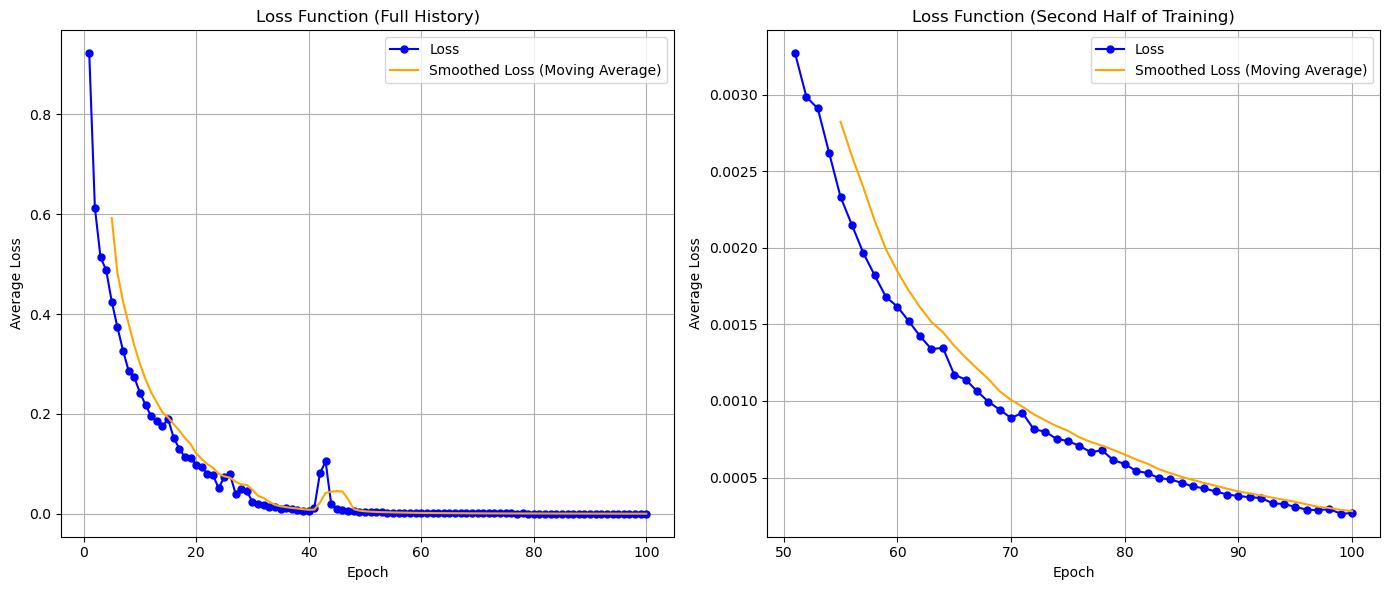

In [47]:
trainer.plot_training_history()

#### Оценка

In [48]:
trainer.evaluate(cifar100)

Classification report for train dataset:
              precision    recall  f1-score   support

    wardrobe     1.0000    1.0000    1.0000       500
  chimpanzee     1.0000    1.0000    1.0000       500
    mushroom     1.0000    1.0000    1.0000       500

    accuracy                         1.0000      1500
   macro avg     1.0000    1.0000    1.0000      1500
weighted avg     1.0000    1.0000    1.0000      1500

--------------------------------------------------
Classification report for test dataset:
              precision    recall  f1-score   support

    wardrobe     0.9252    0.9900    0.9565       100
  chimpanzee     0.9792    0.9400    0.9592       100
    mushroom     0.9794    0.9500    0.9645       100

    accuracy                         0.9600       300
   macro avg     0.9613    0.9600    0.9601       300
weighted avg     0.9613    0.9600    0.9601       300

--------------------------------------------------


#### Сохранение модели в ONNX

In [49]:
trainer.save_model(cifar100)

Model saved as: cifar100_cnn_7_model.onnx


### Эксперимент №5

#### Гиперпараметры

In [50]:
batch_size=2**5
epochs=100
lr_rate = 1e-4
dropout_rate=0.15
hidden_layers=[2**7, 2**8, 2**9, 2**10, 2**11]

#### Инициализация модели

In [51]:
%%time
trainer = CIFAR100Trainer(classes=CLASSES, batch_size=batch_size, lr_rate=lr_rate, dropout_rate=dropout_rate)

Директория для эксперимента 'cifar100_cnn' инициализирована по пути: logs/cifar100_cnn_8
CPU times: user 156 ms, sys: 347 ms, total: 504 ms
Wall time: 363 ms


In [52]:
%%time
cifar100 = CIFAR100ModelCNN(
    hidden_layers=hidden_layers, 
    dropout_rate=dropout_rate, 
    num_classes=CLASSES.__len__()
)

CPU times: user 1.08 s, sys: 159 ms, total: 1.24 s
Wall time: 155 ms


In [53]:
trainer.log_model_graph(cifar100)

Граф модели добавлен в лог: logs/cifar100_cnn_8


#### Информация о модели

In [54]:
cifar100.to(device)

CIFAR100ModelCNN(
  (normalize): Normalize()
  (conv_layers): Sequential(
    (0): Conv2d(3, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(256, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (9): Conv2d(512, 1024, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (10): ReLU(inplace=True)
    (11): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (12): Conv2d(1024, 2048, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): MaxPool2d(kernel_size=2, stride=2, padding=0, dila

In [55]:
summary(cifar100, input_size=(3, 32, 32))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
         Normalize-1            [-1, 3, 32, 32]               0
            Conv2d-2          [-1, 128, 32, 32]           3,584
              ReLU-3          [-1, 128, 32, 32]               0
         MaxPool2d-4          [-1, 128, 16, 16]               0
            Conv2d-5          [-1, 256, 16, 16]         295,168
              ReLU-6          [-1, 256, 16, 16]               0
         MaxPool2d-7            [-1, 256, 8, 8]               0
            Conv2d-8            [-1, 512, 8, 8]       1,180,160
              ReLU-9            [-1, 512, 8, 8]               0
        MaxPool2d-10            [-1, 512, 4, 4]               0
           Conv2d-11           [-1, 1024, 4, 4]       4,719,616
             ReLU-12           [-1, 1024, 4, 4]               0
        MaxPool2d-13           [-1, 1024, 2, 2]               0
           Conv2d-14           [-1, 204

#### Обучение

In [56]:
%%time
trainer.train(cifar100, epochs)

Epoch 1/100: 100%|█████████████████████| 47/47 [00:02<00:00, 22.97batch/s, loss=0.565760, lr=0.000100]


Epoch: 1/100, Loss: 0.755793


Epoch 2/100: 100%|█████████████████████| 47/47 [00:01<00:00, 23.51batch/s, loss=0.238212, lr=0.000100]


Epoch: 2/100, Loss: 0.459294


Epoch 3/100: 100%|█████████████████████| 47/47 [00:01<00:00, 23.54batch/s, loss=0.362380, lr=0.000100]


Epoch: 3/100, Loss: 0.389087


Epoch 4/100: 100%|█████████████████████| 47/47 [00:02<00:00, 23.41batch/s, loss=0.298035, lr=0.000100]


Epoch: 4/100, Loss: 0.251706


Epoch 5/100: 100%|█████████████████████| 47/47 [00:01<00:00, 23.58batch/s, loss=0.359863, lr=0.000100]


Epoch: 5/100, Loss: 0.191113


Epoch 6/100: 100%|█████████████████████| 47/47 [00:02<00:00, 23.35batch/s, loss=0.218060, lr=0.000100]


Epoch: 6/100, Loss: 0.130547


Epoch 7/100: 100%|█████████████████████| 47/47 [00:02<00:00, 23.17batch/s, loss=0.263639, lr=0.000100]


Epoch: 7/100, Loss: 0.082243


Epoch 8/100: 100%|█████████████████████| 47/47 [00:02<00:00, 23.39batch/s, loss=0.023347, lr=0.000100]


Epoch: 8/100, Loss: 0.046029


Epoch 9/100: 100%|█████████████████████| 47/47 [00:02<00:00, 23.34batch/s, loss=0.017734, lr=0.000100]


Epoch: 9/100, Loss: 0.019995


Epoch 10/100: 100%|████████████████████| 47/47 [00:02<00:00, 23.29batch/s, loss=0.006156, lr=0.000100]


Epoch: 10/100, Loss: 0.021528


Epoch 11/100: 100%|████████████████████| 47/47 [00:02<00:00, 23.31batch/s, loss=0.008078, lr=0.000100]


Epoch: 11/100, Loss: 0.011405


Epoch 12/100: 100%|████████████████████| 47/47 [00:02<00:00, 23.32batch/s, loss=0.004045, lr=0.000100]


Epoch: 12/100, Loss: 0.015449


Epoch 13/100: 100%|████████████████████| 47/47 [00:02<00:00, 23.32batch/s, loss=0.010500, lr=0.000100]


Epoch: 13/100, Loss: 0.015526


Epoch 14/100: 100%|████████████████████| 47/47 [00:01<00:00, 23.65batch/s, loss=0.002952, lr=0.000100]


Epoch: 14/100, Loss: 0.009233


Epoch 15/100: 100%|████████████████████| 47/47 [00:02<00:00, 23.43batch/s, loss=0.001894, lr=0.000100]


Epoch: 15/100, Loss: 0.002286


Epoch 16/100: 100%|████████████████████| 47/47 [00:02<00:00, 23.42batch/s, loss=0.000904, lr=0.000100]


Epoch: 16/100, Loss: 0.000764


Epoch 17/100: 100%|████████████████████| 47/47 [00:01<00:00, 23.56batch/s, loss=0.000454, lr=0.000100]


Epoch: 17/100, Loss: 0.000467


Epoch 18/100: 100%|████████████████████| 47/47 [00:02<00:00, 23.18batch/s, loss=0.001851, lr=0.000100]


Epoch: 18/100, Loss: 0.000354


Epoch 19/100: 100%|████████████████████| 47/47 [00:02<00:00, 23.04batch/s, loss=0.000562, lr=0.000100]


Epoch: 19/100, Loss: 0.000294


Epoch 20/100: 100%|████████████████████| 47/47 [00:02<00:00, 23.04batch/s, loss=0.000353, lr=0.000100]


Epoch: 20/100, Loss: 0.000243


Epoch 21/100: 100%|████████████████████| 47/47 [00:02<00:00, 23.44batch/s, loss=0.000098, lr=0.000100]


Epoch: 21/100, Loss: 0.000216


Epoch 22/100: 100%|████████████████████| 47/47 [00:01<00:00, 23.56batch/s, loss=0.000140, lr=0.000100]


Epoch: 22/100, Loss: 0.000185


Epoch 23/100: 100%|████████████████████| 47/47 [00:02<00:00, 23.48batch/s, loss=0.000093, lr=0.000100]


Epoch: 23/100, Loss: 0.000166


Epoch 24/100: 100%|████████████████████| 47/47 [00:02<00:00, 23.04batch/s, loss=0.000171, lr=0.000100]


Epoch: 24/100, Loss: 0.000149


Epoch 25/100: 100%|████████████████████| 47/47 [00:02<00:00, 23.03batch/s, loss=0.000110, lr=0.000100]


Epoch: 25/100, Loss: 0.000135


Epoch 26/100: 100%|████████████████████| 47/47 [00:02<00:00, 23.06batch/s, loss=0.000045, lr=0.000100]


Epoch: 26/100, Loss: 0.000122


Epoch 27/100: 100%|████████████████████| 47/47 [00:02<00:00, 23.11batch/s, loss=0.000064, lr=0.000100]


Epoch: 27/100, Loss: 0.000114


Epoch 28/100: 100%|████████████████████| 47/47 [00:01<00:00, 23.60batch/s, loss=0.000091, lr=0.000100]


Epoch: 28/100, Loss: 0.000104


Epoch 29/100: 100%|████████████████████| 47/47 [00:01<00:00, 23.84batch/s, loss=0.000077, lr=0.000100]


Epoch: 29/100, Loss: 0.000096


Epoch 30/100: 100%|████████████████████| 47/47 [00:01<00:00, 23.90batch/s, loss=0.000058, lr=0.000100]


Epoch: 30/100, Loss: 0.000090


Epoch 31/100: 100%|████████████████████| 47/47 [00:01<00:00, 23.83batch/s, loss=0.000058, lr=0.000100]


Epoch: 31/100, Loss: 0.000083


Epoch 32/100: 100%|████████████████████| 47/47 [00:01<00:00, 23.85batch/s, loss=0.000124, lr=0.000100]


Epoch: 32/100, Loss: 0.000078


Epoch 33/100: 100%|████████████████████| 47/47 [00:01<00:00, 23.73batch/s, loss=0.000084, lr=0.000100]


Epoch: 33/100, Loss: 0.000073


Epoch 34/100: 100%|████████████████████| 47/47 [00:01<00:00, 23.79batch/s, loss=0.000039, lr=0.000100]


Epoch: 34/100, Loss: 0.000068


Epoch 35/100: 100%|████████████████████| 47/47 [00:01<00:00, 23.55batch/s, loss=0.000031, lr=0.000100]


Epoch: 35/100, Loss: 0.000064


Epoch 36/100: 100%|████████████████████| 47/47 [00:02<00:00, 23.01batch/s, loss=0.000077, lr=0.000100]


Epoch: 36/100, Loss: 0.000060


Epoch 37/100: 100%|████████████████████| 47/47 [00:02<00:00, 23.01batch/s, loss=0.000060, lr=0.000100]


Epoch: 37/100, Loss: 0.000057


Epoch 38/100: 100%|████████████████████| 47/47 [00:02<00:00, 23.10batch/s, loss=0.000016, lr=0.000100]


Epoch: 38/100, Loss: 0.000053


Epoch 39/100: 100%|████████████████████| 47/47 [00:02<00:00, 23.20batch/s, loss=0.000075, lr=0.000100]


Epoch: 39/100, Loss: 0.000051


Epoch 40/100: 100%|████████████████████| 47/47 [00:02<00:00, 22.98batch/s, loss=0.000046, lr=0.000100]


Epoch: 40/100, Loss: 0.000047


Epoch 41/100: 100%|████████████████████| 47/47 [00:02<00:00, 23.10batch/s, loss=0.000076, lr=0.000100]


Epoch: 41/100, Loss: 0.000045


Epoch 42/100: 100%|████████████████████| 47/47 [00:02<00:00, 22.93batch/s, loss=0.000062, lr=0.000100]


Epoch: 42/100, Loss: 0.000043


Epoch 43/100: 100%|████████████████████| 47/47 [00:02<00:00, 23.03batch/s, loss=0.000047, lr=0.000100]


Epoch: 43/100, Loss: 0.000040


Epoch 44/100: 100%|████████████████████| 47/47 [00:02<00:00, 23.38batch/s, loss=0.000033, lr=0.000100]


Epoch: 44/100, Loss: 0.000038


Epoch 45/100: 100%|████████████████████| 47/47 [00:02<00:00, 23.48batch/s, loss=0.000041, lr=0.000100]


Epoch: 45/100, Loss: 0.000037


Epoch 46/100: 100%|████████████████████| 47/47 [00:02<00:00, 23.28batch/s, loss=0.000016, lr=0.000100]


Epoch: 46/100, Loss: 0.000035


Epoch 47/100: 100%|████████████████████| 47/47 [00:02<00:00, 23.25batch/s, loss=0.000005, lr=0.000100]


Epoch: 47/100, Loss: 0.000033


Epoch 48/100: 100%|████████████████████| 47/47 [00:02<00:00, 22.99batch/s, loss=0.000033, lr=0.000100]


Epoch: 48/100, Loss: 0.000032


Epoch 49/100: 100%|████████████████████| 47/47 [00:02<00:00, 23.44batch/s, loss=0.000019, lr=0.000100]


Epoch: 49/100, Loss: 0.000031


Epoch 50/100: 100%|████████████████████| 47/47 [00:02<00:00, 23.32batch/s, loss=0.000030, lr=0.000100]


Epoch: 50/100, Loss: 0.000029


Epoch 51/100: 100%|████████████████████| 47/47 [00:02<00:00, 23.36batch/s, loss=0.000012, lr=0.000100]


Epoch: 51/100, Loss: 0.000028


Epoch 52/100: 100%|████████████████████| 47/47 [00:02<00:00, 23.42batch/s, loss=0.000011, lr=0.000100]


Epoch: 52/100, Loss: 0.000026


Epoch 53/100: 100%|████████████████████| 47/47 [00:01<00:00, 23.57batch/s, loss=0.000030, lr=0.000100]


Epoch: 53/100, Loss: 0.000025


Epoch 54/100: 100%|████████████████████| 47/47 [00:01<00:00, 23.70batch/s, loss=0.000004, lr=0.000100]


Epoch: 54/100, Loss: 0.000024


Epoch 55/100: 100%|████████████████████| 47/47 [00:01<00:00, 23.86batch/s, loss=0.000011, lr=0.000100]


Epoch: 55/100, Loss: 0.000023


Epoch 56/100: 100%|████████████████████| 47/47 [00:01<00:00, 23.86batch/s, loss=0.000006, lr=0.000100]


Epoch: 56/100, Loss: 0.000022


Epoch 57/100: 100%|████████████████████| 47/47 [00:01<00:00, 23.85batch/s, loss=0.000028, lr=0.000100]


Epoch: 57/100, Loss: 0.000021


Epoch 58/100: 100%|████████████████████| 47/47 [00:01<00:00, 23.83batch/s, loss=0.000014, lr=0.000100]


Epoch: 58/100, Loss: 0.000021


Epoch 59/100: 100%|████████████████████| 47/47 [00:01<00:00, 23.80batch/s, loss=0.000023, lr=0.000100]


Epoch: 59/100, Loss: 0.000020


Epoch 60/100: 100%|████████████████████| 47/47 [00:01<00:00, 23.57batch/s, loss=0.000030, lr=0.000100]


Epoch: 60/100, Loss: 0.000019


Epoch 61/100: 100%|████████████████████| 47/47 [00:01<00:00, 23.53batch/s, loss=0.000012, lr=0.000100]


Epoch: 61/100, Loss: 0.000018


Epoch 62/100: 100%|████████████████████| 47/47 [00:01<00:00, 23.54batch/s, loss=0.000010, lr=0.000100]


Epoch: 62/100, Loss: 0.000017


Epoch 63/100: 100%|████████████████████| 47/47 [00:01<00:00, 23.51batch/s, loss=0.000026, lr=0.000100]


Epoch: 63/100, Loss: 0.000017


Epoch 64/100: 100%|████████████████████| 47/47 [00:01<00:00, 23.58batch/s, loss=0.000017, lr=0.000100]


Epoch: 64/100, Loss: 0.000016


Epoch 65/100: 100%|████████████████████| 47/47 [00:02<00:00, 23.13batch/s, loss=0.000013, lr=0.000100]


Epoch: 65/100, Loss: 0.000016


Epoch 66/100: 100%|████████████████████| 47/47 [00:02<00:00, 23.06batch/s, loss=0.000026, lr=0.000100]


Epoch: 66/100, Loss: 0.000015


Epoch 67/100: 100%|████████████████████| 47/47 [00:02<00:00, 23.09batch/s, loss=0.000004, lr=0.000100]


Epoch: 67/100, Loss: 0.000014


Epoch 68/100: 100%|████████████████████| 47/47 [00:02<00:00, 23.28batch/s, loss=0.000005, lr=0.000100]


Epoch: 68/100, Loss: 0.000014


Epoch 69/100: 100%|████████████████████| 47/47 [00:02<00:00, 23.01batch/s, loss=0.000020, lr=0.000100]


Epoch: 69/100, Loss: 0.000013


Epoch 70/100: 100%|████████████████████| 47/47 [00:02<00:00, 22.99batch/s, loss=0.000011, lr=0.000100]


Epoch: 70/100, Loss: 0.000013


Epoch 71/100: 100%|████████████████████| 47/47 [00:02<00:00, 23.07batch/s, loss=0.000010, lr=0.000100]


Epoch: 71/100, Loss: 0.000012


Epoch 72/100: 100%|████████████████████| 47/47 [00:02<00:00, 22.98batch/s, loss=0.000009, lr=0.000100]


Epoch: 72/100, Loss: 0.000012


Epoch 73/100: 100%|████████████████████| 47/47 [00:02<00:00, 22.93batch/s, loss=0.000010, lr=0.000100]


Epoch: 73/100, Loss: 0.000011


Epoch 74/100: 100%|████████████████████| 47/47 [00:02<00:00, 23.00batch/s, loss=0.000017, lr=0.000100]


Epoch: 74/100, Loss: 0.000011


Epoch 75/100: 100%|████████████████████| 47/47 [00:02<00:00, 22.97batch/s, loss=0.000003, lr=0.000100]


Epoch: 75/100, Loss: 0.000010


Epoch 76/100: 100%|████████████████████| 47/47 [00:02<00:00, 23.04batch/s, loss=0.000011, lr=0.000100]


Epoch: 76/100, Loss: 0.000010


Epoch 77/100: 100%|████████████████████| 47/47 [00:02<00:00, 23.02batch/s, loss=0.000005, lr=0.000100]


Epoch: 77/100, Loss: 0.000010


Epoch 78/100: 100%|████████████████████| 47/47 [00:02<00:00, 23.01batch/s, loss=0.000003, lr=0.000100]


Epoch: 78/100, Loss: 0.000009


Epoch 79/100: 100%|████████████████████| 47/47 [00:02<00:00, 23.02batch/s, loss=0.000018, lr=0.000100]


Epoch: 79/100, Loss: 0.000009


Epoch 80/100: 100%|████████████████████| 47/47 [00:02<00:00, 23.10batch/s, loss=0.000007, lr=0.000100]


Epoch: 80/100, Loss: 0.000009


Epoch 81/100: 100%|████████████████████| 47/47 [00:02<00:00, 23.04batch/s, loss=0.000004, lr=0.000100]


Epoch: 81/100, Loss: 0.000008


Epoch 82/100: 100%|████████████████████| 47/47 [00:02<00:00, 23.27batch/s, loss=0.000007, lr=0.000100]


Epoch: 82/100, Loss: 0.000008


Epoch 83/100: 100%|████████████████████| 47/47 [00:01<00:00, 23.52batch/s, loss=0.000010, lr=0.000100]


Epoch: 83/100, Loss: 0.000008


Epoch 84/100: 100%|████████████████████| 47/47 [00:02<00:00, 23.29batch/s, loss=0.000010, lr=0.000100]


Epoch: 84/100, Loss: 0.000007


Epoch 85/100: 100%|████████████████████| 47/47 [00:02<00:00, 23.26batch/s, loss=0.000017, lr=0.000100]


Epoch: 85/100, Loss: 0.000007


Epoch 86/100: 100%|████████████████████| 47/47 [00:01<00:00, 23.52batch/s, loss=0.000012, lr=0.000100]


Epoch: 86/100, Loss: 0.000007


Epoch 87/100: 100%|████████████████████| 47/47 [00:02<00:00, 23.46batch/s, loss=0.000012, lr=0.000100]


Epoch: 87/100, Loss: 0.000007


Epoch 88/100: 100%|████████████████████| 47/47 [00:01<00:00, 23.55batch/s, loss=0.000002, lr=0.000100]


Epoch: 88/100, Loss: 0.000006


Epoch 89/100: 100%|████████████████████| 47/47 [00:02<00:00, 23.43batch/s, loss=0.000002, lr=0.000100]


Epoch: 89/100, Loss: 0.000006


Epoch 90/100: 100%|████████████████████| 47/47 [00:02<00:00, 23.00batch/s, loss=0.000003, lr=0.000100]


Epoch: 90/100, Loss: 0.000006


Epoch 91/100: 100%|████████████████████| 47/47 [00:02<00:00, 23.31batch/s, loss=0.000004, lr=0.000100]


Epoch: 91/100, Loss: 0.000006


Epoch 92/100: 100%|████████████████████| 47/47 [00:02<00:00, 23.19batch/s, loss=0.000007, lr=0.000100]


Epoch: 92/100, Loss: 0.000005


Epoch 93/100: 100%|████████████████████| 47/47 [00:02<00:00, 23.07batch/s, loss=0.000005, lr=0.000100]


Epoch: 93/100, Loss: 0.000005


Epoch 94/100: 100%|████████████████████| 47/47 [00:02<00:00, 23.14batch/s, loss=0.000009, lr=0.000100]


Epoch: 94/100, Loss: 0.000005


Epoch 95/100: 100%|████████████████████| 47/47 [00:02<00:00, 23.19batch/s, loss=0.000001, lr=0.000100]


Epoch: 95/100, Loss: 0.000005


Epoch 96/100: 100%|████████████████████| 47/47 [00:02<00:00, 23.48batch/s, loss=0.000006, lr=0.000100]


Epoch: 96/100, Loss: 0.000005


Epoch 97/100: 100%|████████████████████| 47/47 [00:02<00:00, 23.33batch/s, loss=0.000003, lr=0.000100]


Epoch: 97/100, Loss: 0.000004


Epoch 98/100: 100%|████████████████████| 47/47 [00:02<00:00, 23.46batch/s, loss=0.000001, lr=0.000100]


Epoch: 98/100, Loss: 0.000004


Epoch 99/100: 100%|████████████████████| 47/47 [00:02<00:00, 23.25batch/s, loss=0.000007, lr=0.000100]


Epoch: 99/100, Loss: 0.000004


Epoch 100/100: 100%|███████████████████| 47/47 [00:02<00:00, 22.96batch/s, loss=0.000003, lr=0.000100]

Epoch: 100/100, Loss: 0.000004
CPU times: user 56.3 s, sys: 2min 28s, total: 3min 24s
Wall time: 3min 21s


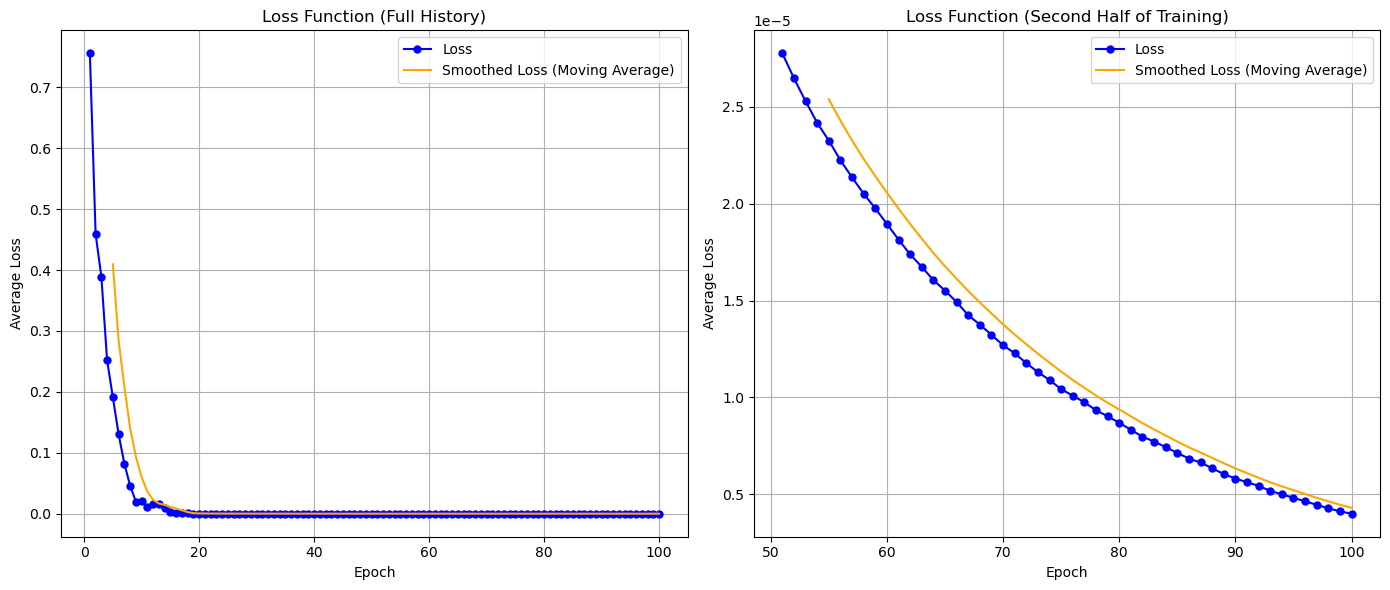

In [57]:
trainer.plot_training_history()

#### Оценка

In [58]:
trainer.evaluate(cifar100)

Classification report for train dataset:
              precision    recall  f1-score   support

    wardrobe     1.0000    1.0000    1.0000       500
  chimpanzee     1.0000    1.0000    1.0000       500
    mushroom     1.0000    1.0000    1.0000       500

    accuracy                         1.0000      1500
   macro avg     1.0000    1.0000    1.0000      1500
weighted avg     1.0000    1.0000    1.0000      1500

--------------------------------------------------
Classification report for test dataset:
              precision    recall  f1-score   support

    wardrobe     0.9429    0.9900    0.9659       100
  chimpanzee     0.9694    0.9500    0.9596       100
    mushroom     0.9691    0.9400    0.9543       100

    accuracy                         0.9600       300
   macro avg     0.9604    0.9600    0.9599       300
weighted avg     0.9604    0.9600    0.9599       300

--------------------------------------------------


#### Сохранение модели в ONNX

In [59]:
trainer.save_model(cifar100)

Model saved as: cifar100_cnn_8_model.onnx
